# Invasion of 027 into Caco-2 cells

In [1]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pystan 
import pandas as pd
import seaborn as sns
import math
import statistics as st
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from matplotlib.patches import Ellipse
from scipy import stats
from tqdm.notebook import tqdm as tqdm
import warnings

In [2]:
datum = pd.read_csv('Data/027.csv') 
#Import features from data set
Time=datum.iloc[:, 0].values
LogDose=datum.iloc[:, 1].values
CFU=datum.iloc[:, 2].values
LogCFU=datum.iloc[:, 3].values
Rate=datum.iloc[:, 4].values
LogRate=datum.iloc[:, 5].values

def classification(column):
    CLASS=sorted(list(set(column)))
    return CLASS

class_LogDose=classification(LogDose)

Initial_8=datum[datum["LogDose"]==class_LogDose[5]]
Initial_7=datum[datum["LogDose"]==class_LogDose[4]]
Initial_6=datum[datum["LogDose"]==class_LogDose[3]]
Initial_5=datum[datum["LogDose"]==class_LogDose[2]]
Initial_4=datum[datum["LogDose"]==class_LogDose[1]]
Initial_3=datum[datum["LogDose"]==class_LogDose[0]]

datum=deepcopy(datum.dropna())
Initial_8=deepcopy(Initial_8.dropna())
Initial_7=deepcopy(Initial_7.dropna())
Initial_6=deepcopy(Initial_6.dropna())
Initial_5=deepcopy(Initial_5.dropna())
Initial_4=deepcopy(Initial_4.dropna())
Initial_3=deepcopy(Initial_3.dropna())

Fitting=pd.concat([Initial_4, Initial_6, Initial_8])

datum = datum.reset_index()
datum

index       Time   LogDose           CFU    LogCFU          Rate  \
0        0   0.002778  8.635149     23.880597  1.378045  1.853280e-07   
1        2   0.002778  8.635149     11.940299  1.077015  9.266410e-08   
2        3   1.500000  8.635149  23432.835820  4.369825  1.818530e-04   
3        4   1.500000  8.635149  82537.313430  4.916650  6.405410e-04   
4        5   1.500000  8.635149  37462.686570  4.573599  2.907340e-04   
..     ...        ...       ...           ...       ...           ...   
131    157  10.500000  3.698970     92.537313  1.966317  6.200000e-02   
132    158  10.500000  3.698970     29.850746  1.474955  2.000000e-02   
133    159  12.000000  3.698970    170.149254  2.230830  1.140000e-01   
134    160  12.000000  3.698970    100.000000  2.000000  6.700000e-02   
135    161  12.000000  3.698970     95.522388  1.980105  6.400000e-02   

      LogRate  
0   -6.732059  
1   -7.033089  
2   -3.740279  
3   -3.193453  
4   -3.536505  
..        ...  
131 -1.207608  
132 -1.698970  
133 -0.943095  
134 -1.173925  
135 -1.193820  

[136 rows x 7 columns]

In [3]:
sm1 = pickle.load(open('new stan model.pkl', 'rb'))

fit_nuts = sm1.sampling(
    data = dict(LogN = np.log10(0.335*10**Fitting.LogCFU), t = Fitting.Time, LogNdose = Fitting.LogDose, V = 0.1, S = 0.32, n = len(Fitting.Time)), 
    iter = 3000, chains = 4, thin = 1, warmup = 500, seed = 12345, control = dict(adapt_delta = 0.80, max_treedepth = 20)
    ) 
print(fit_nuts)
#Rhat: Gelman-Rubin

Inference for Stan model: anon_model_9981b91acc61f17b4ba9e6690c401580.
4 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
LogNmax            4.93  2.1e-3   0.13   4.69   4.85   4.93   5.02   5.21   3980    1.0
Logmu             -8.82  2.5e-3   0.16  -9.15  -8.92  -8.81  -8.71  -8.52   3911    1.0
sigma              0.55  6.8e-4   0.05   0.46   0.51   0.54   0.58   0.65   5308    1.0
LogPredicted[1]    0.52  8.3e-4   0.08   0.35   0.46   0.51   0.57   0.68   9929    1.0
LogPredicted[2]    0.82  8.3e-4   0.08   0.66   0.76   0.82   0.87   0.98   9929    1.0
LogPredicted[3]    0.82  8.3e-4   0.08   0.66   0.76   0.82   0.87   0.98   9929    1.0
LogPredicted[4]    0.99  8.3e-4   0.08   0.83   0.94   0.99   1.05   1.16   9930    1.0
LogPredicted[5]    0.99  8.3e-4   0.08   0.83   0.94   0.99   1.05   1.16   9930    1.0
LogPredicted[6]    

In [4]:
samples = fit_nuts.extract(permuted = False, inc_warmup = True)
paraname = fit_nuts.sim["fnames_oi"]
palette = sns.color_palette()
ms = fit_nuts.extract(permuted=False, inc_warmup=True)
iter_from = fit_nuts.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit_nuts.sim['fnames_oi']
num_pages = math.ceil(len(paraname)/4)


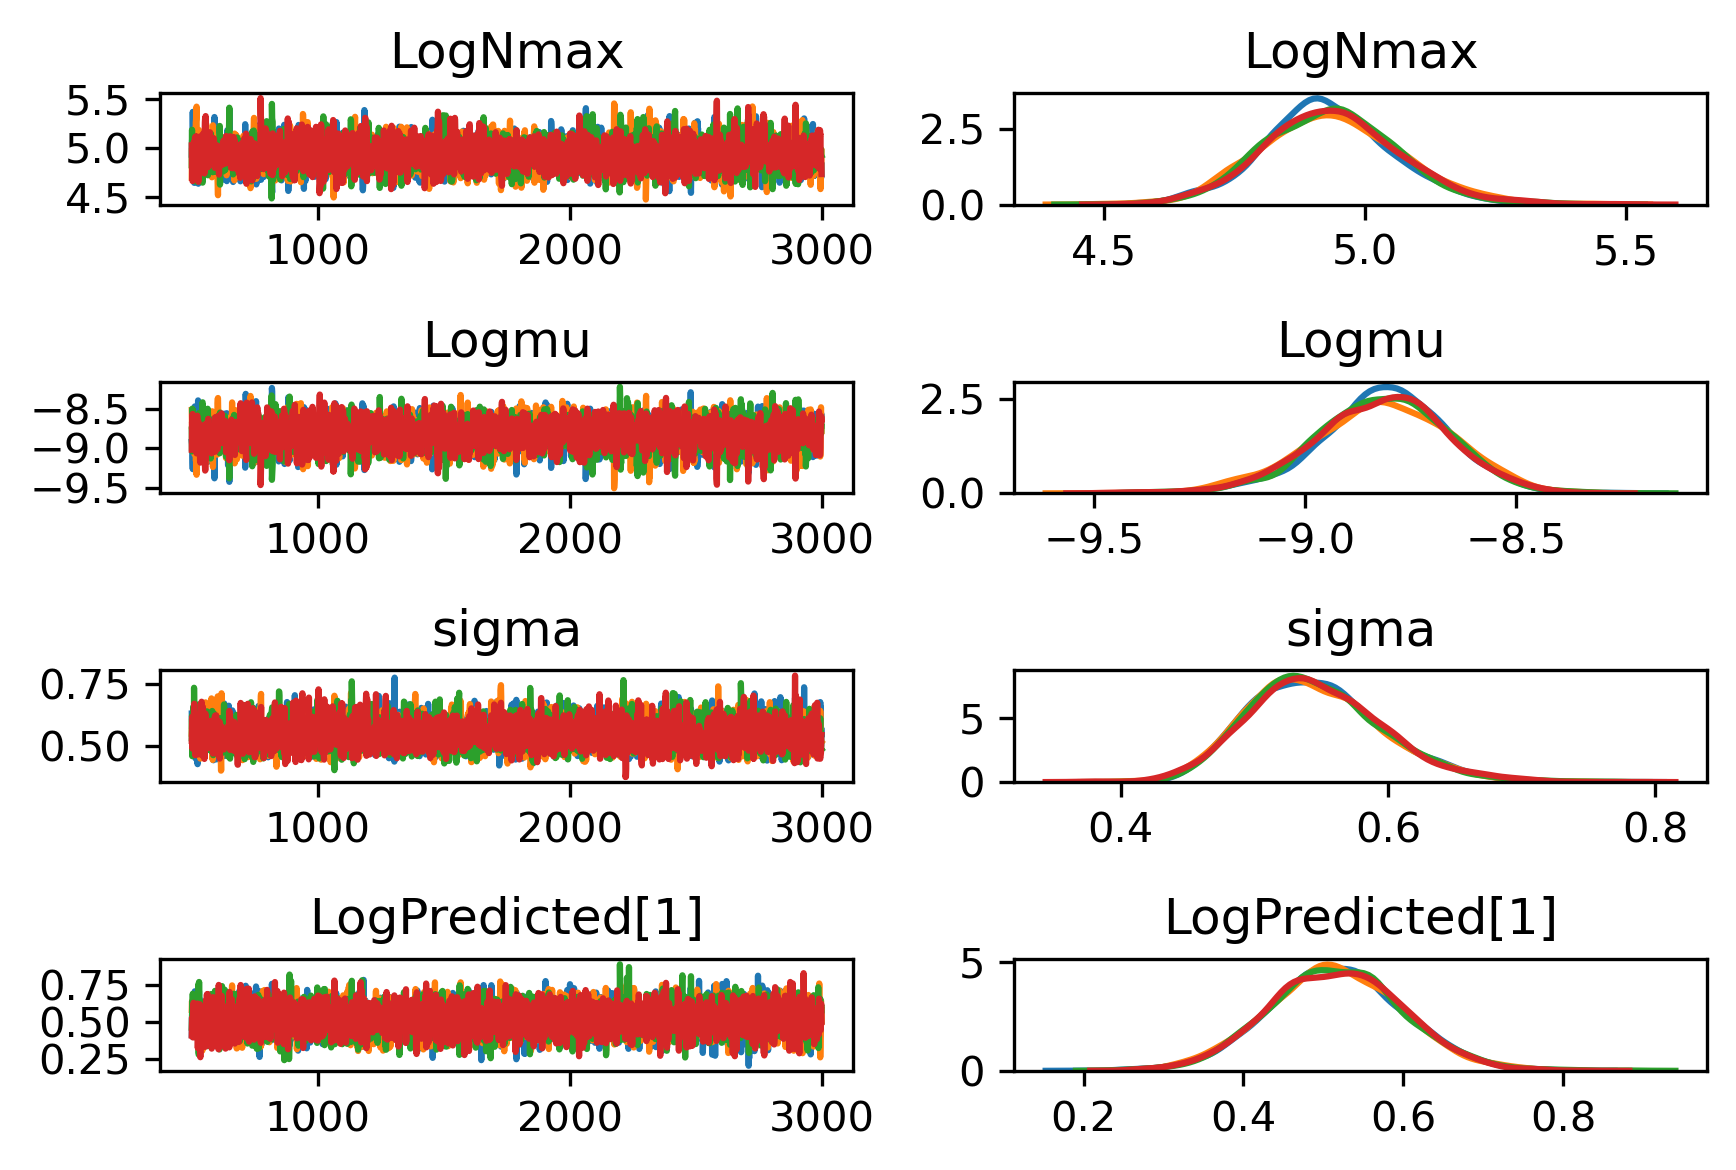

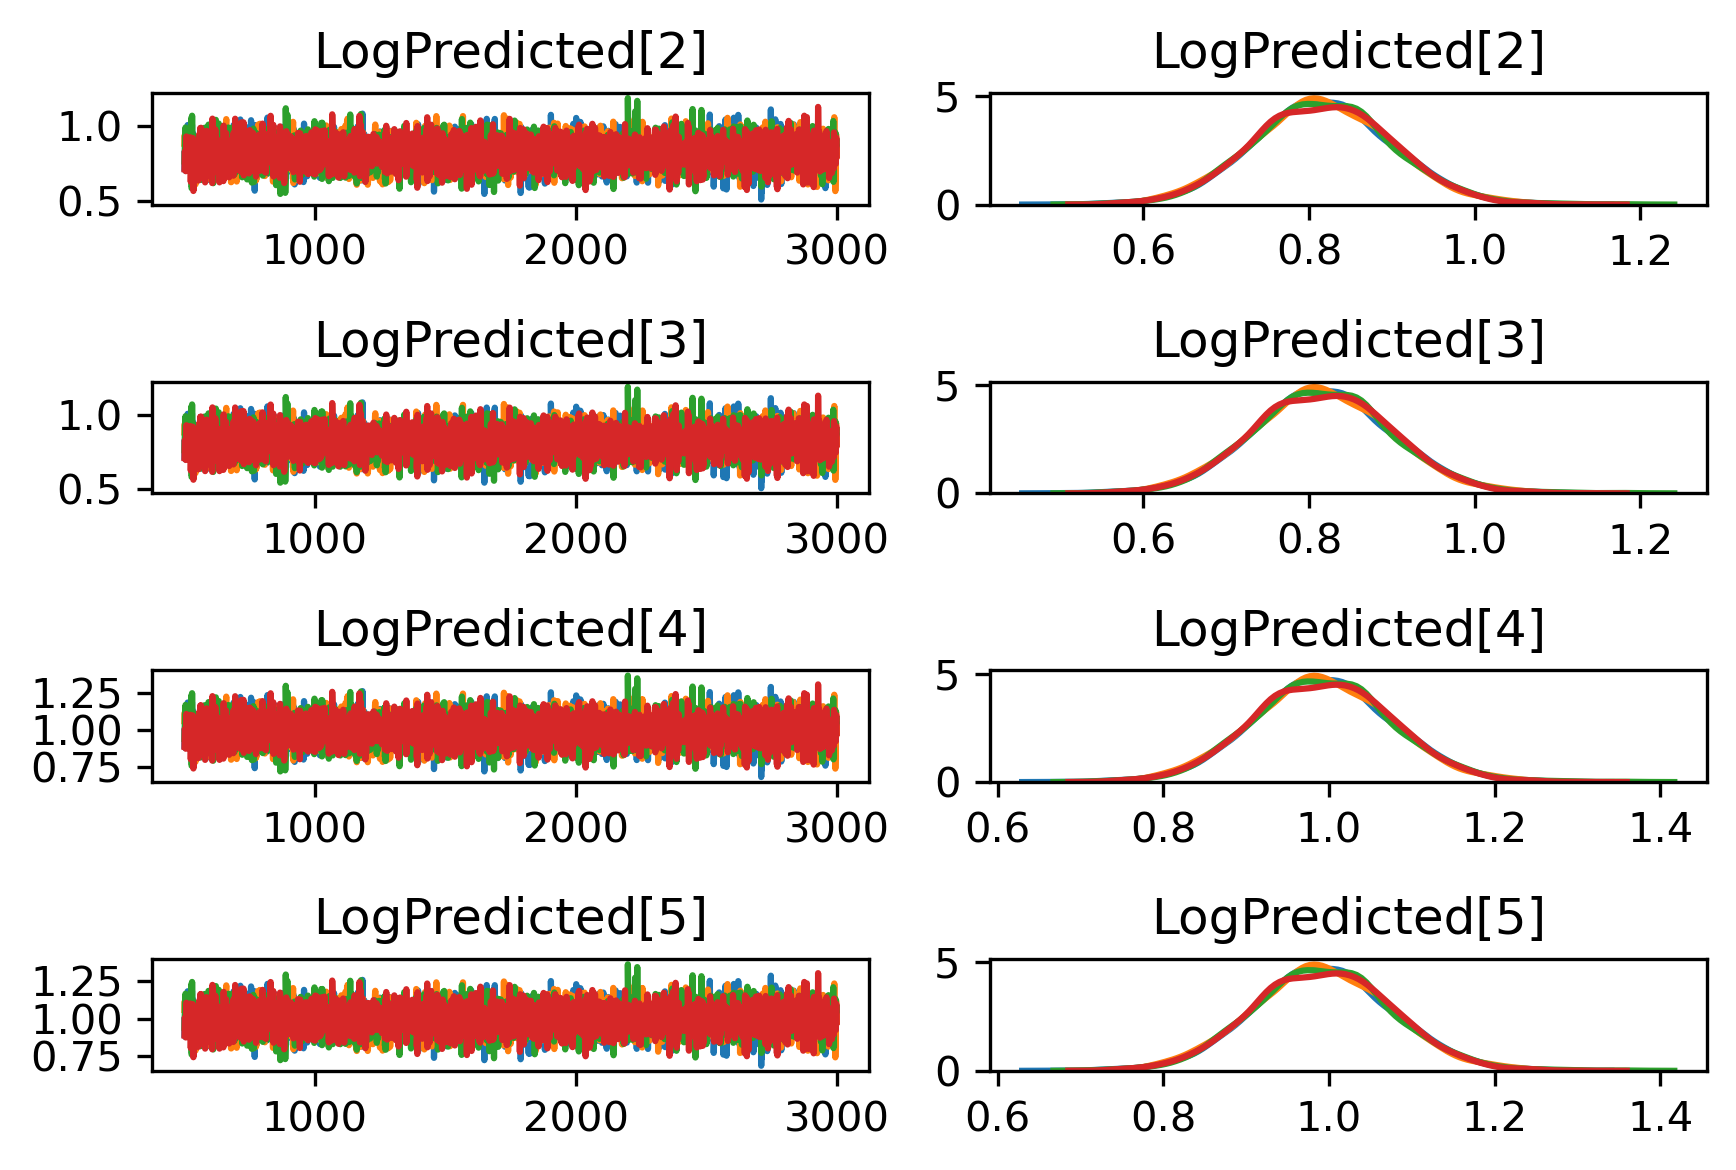

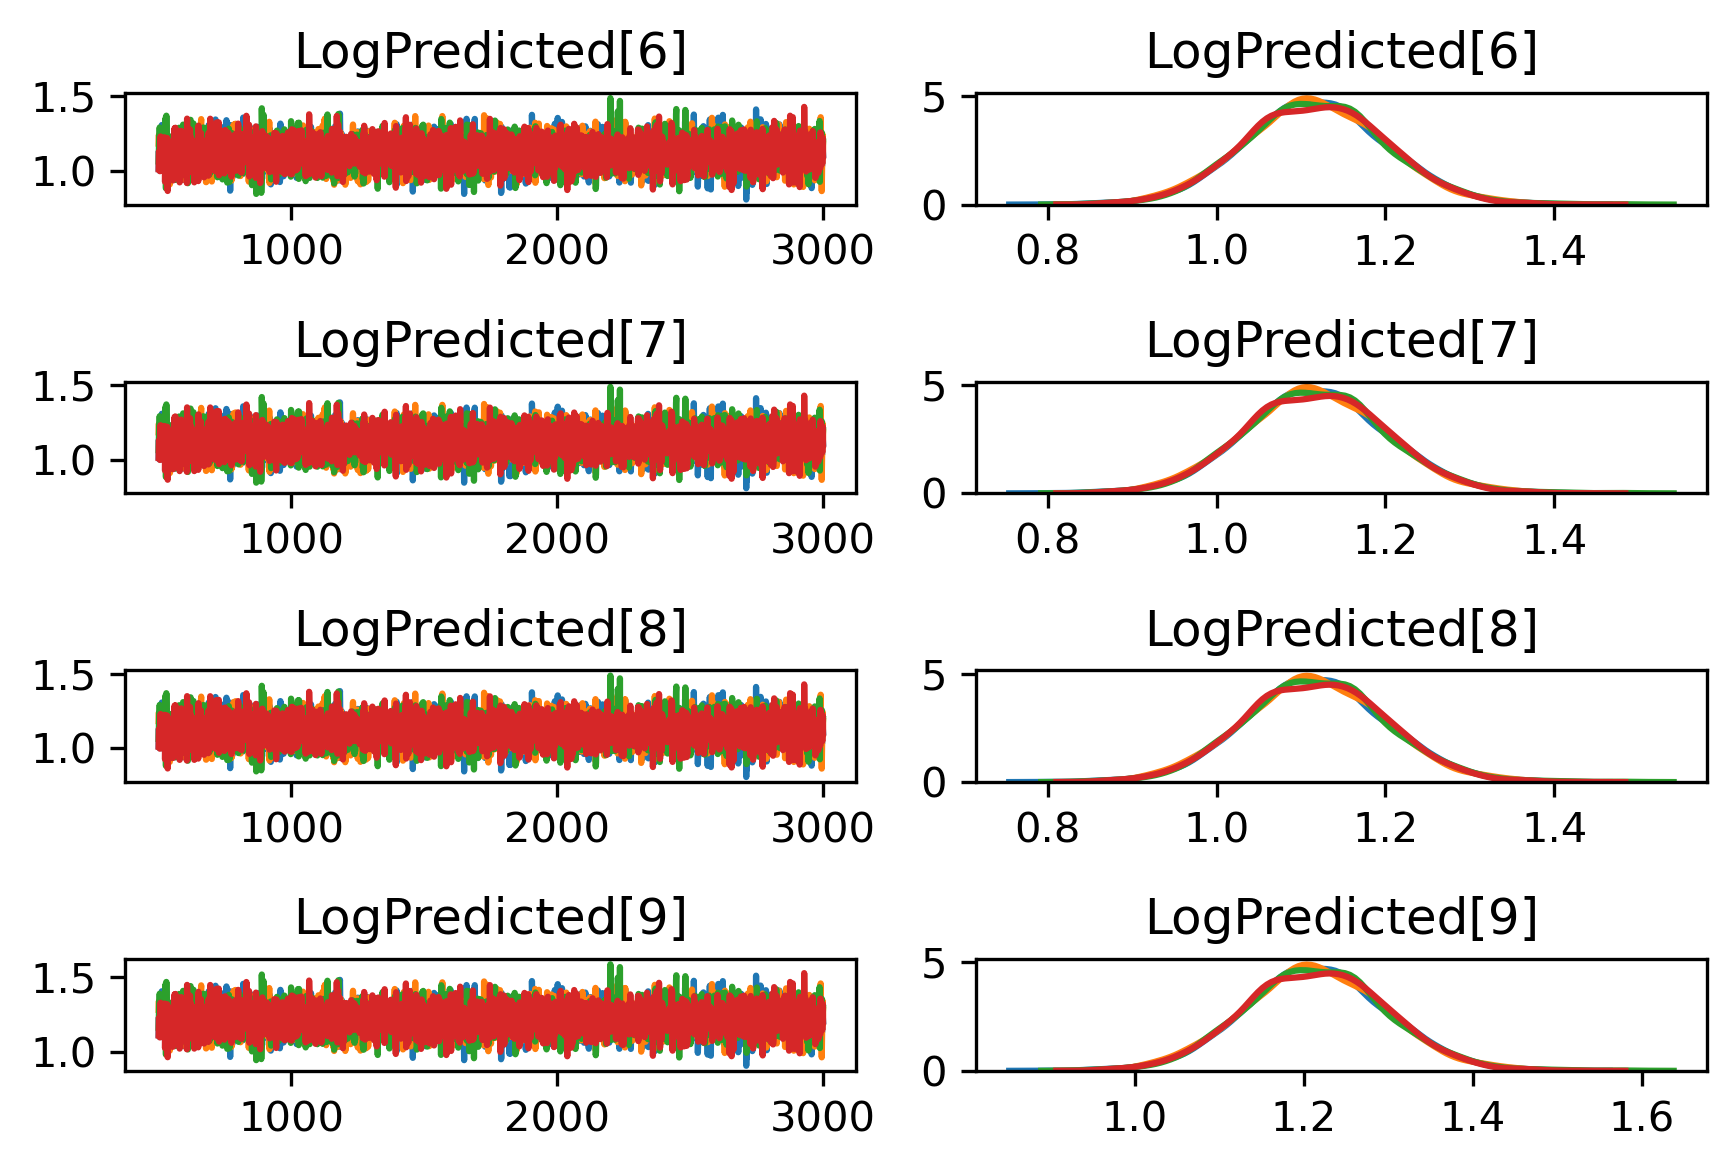

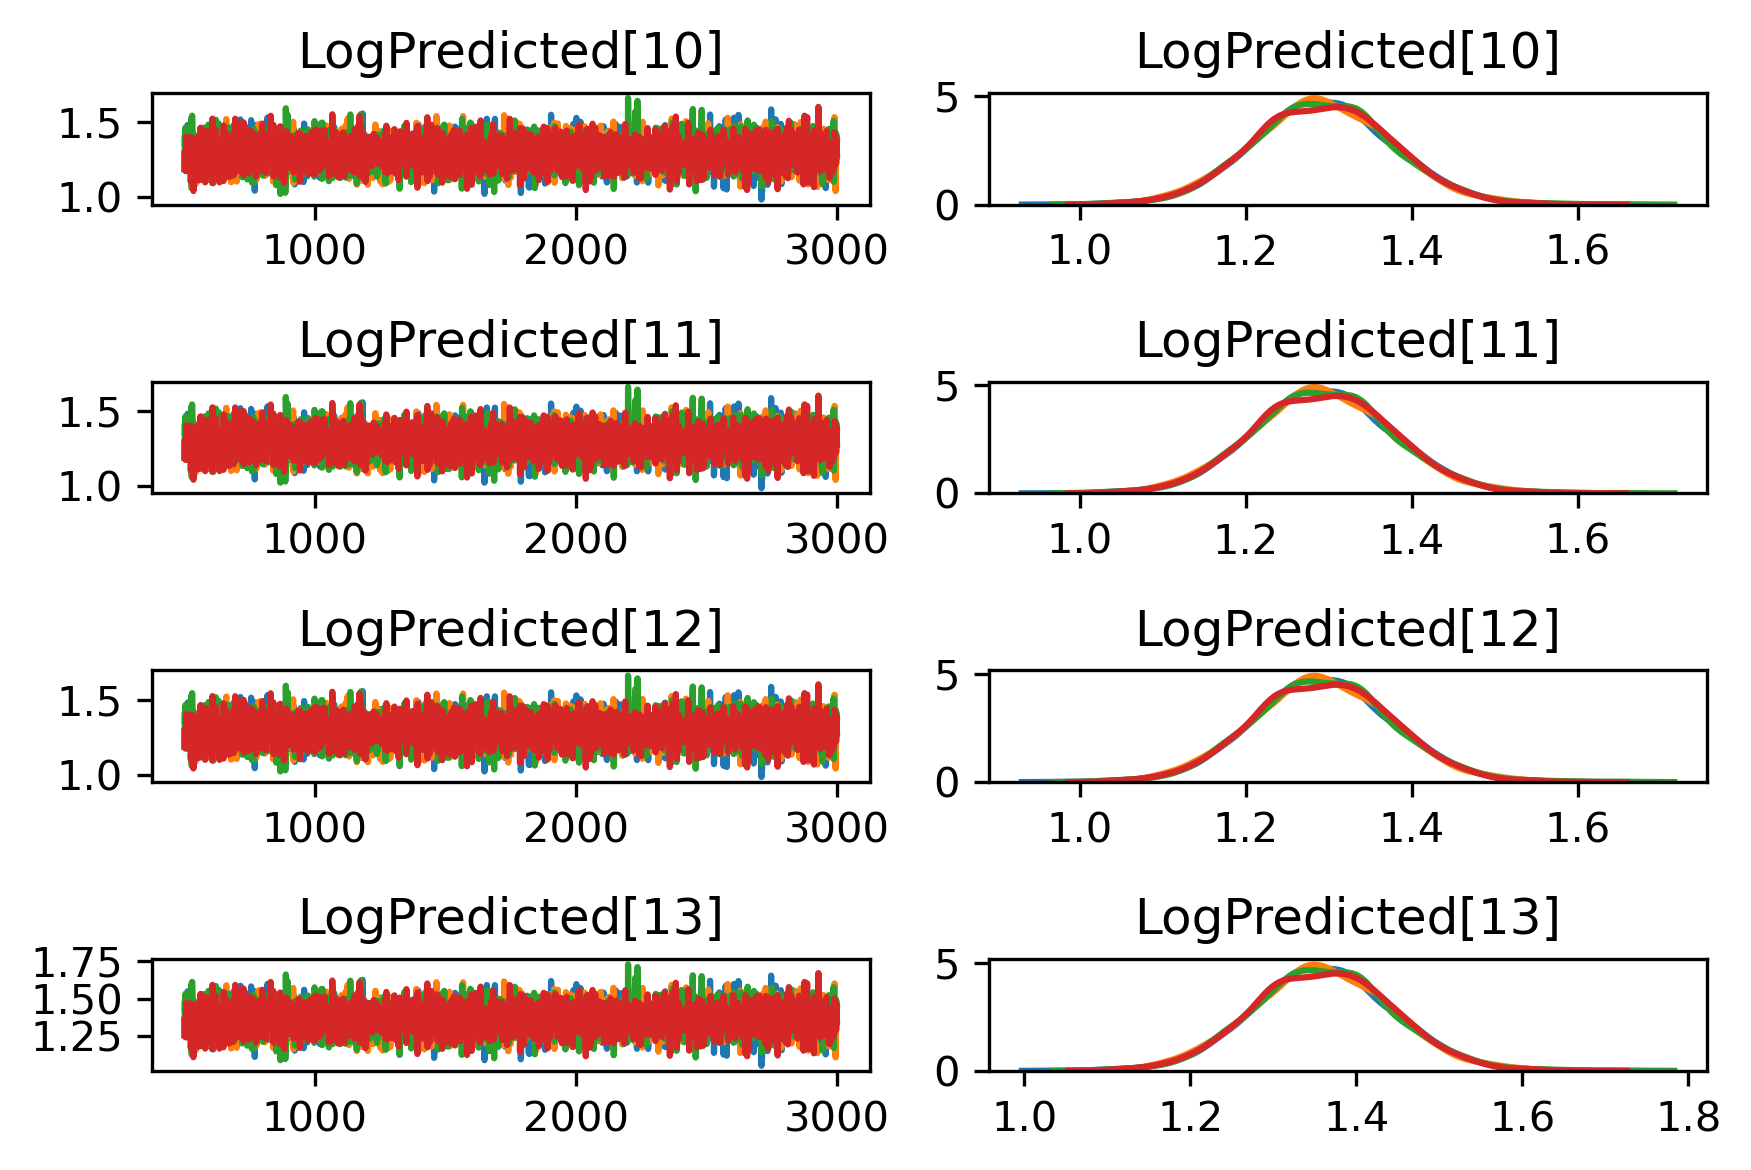

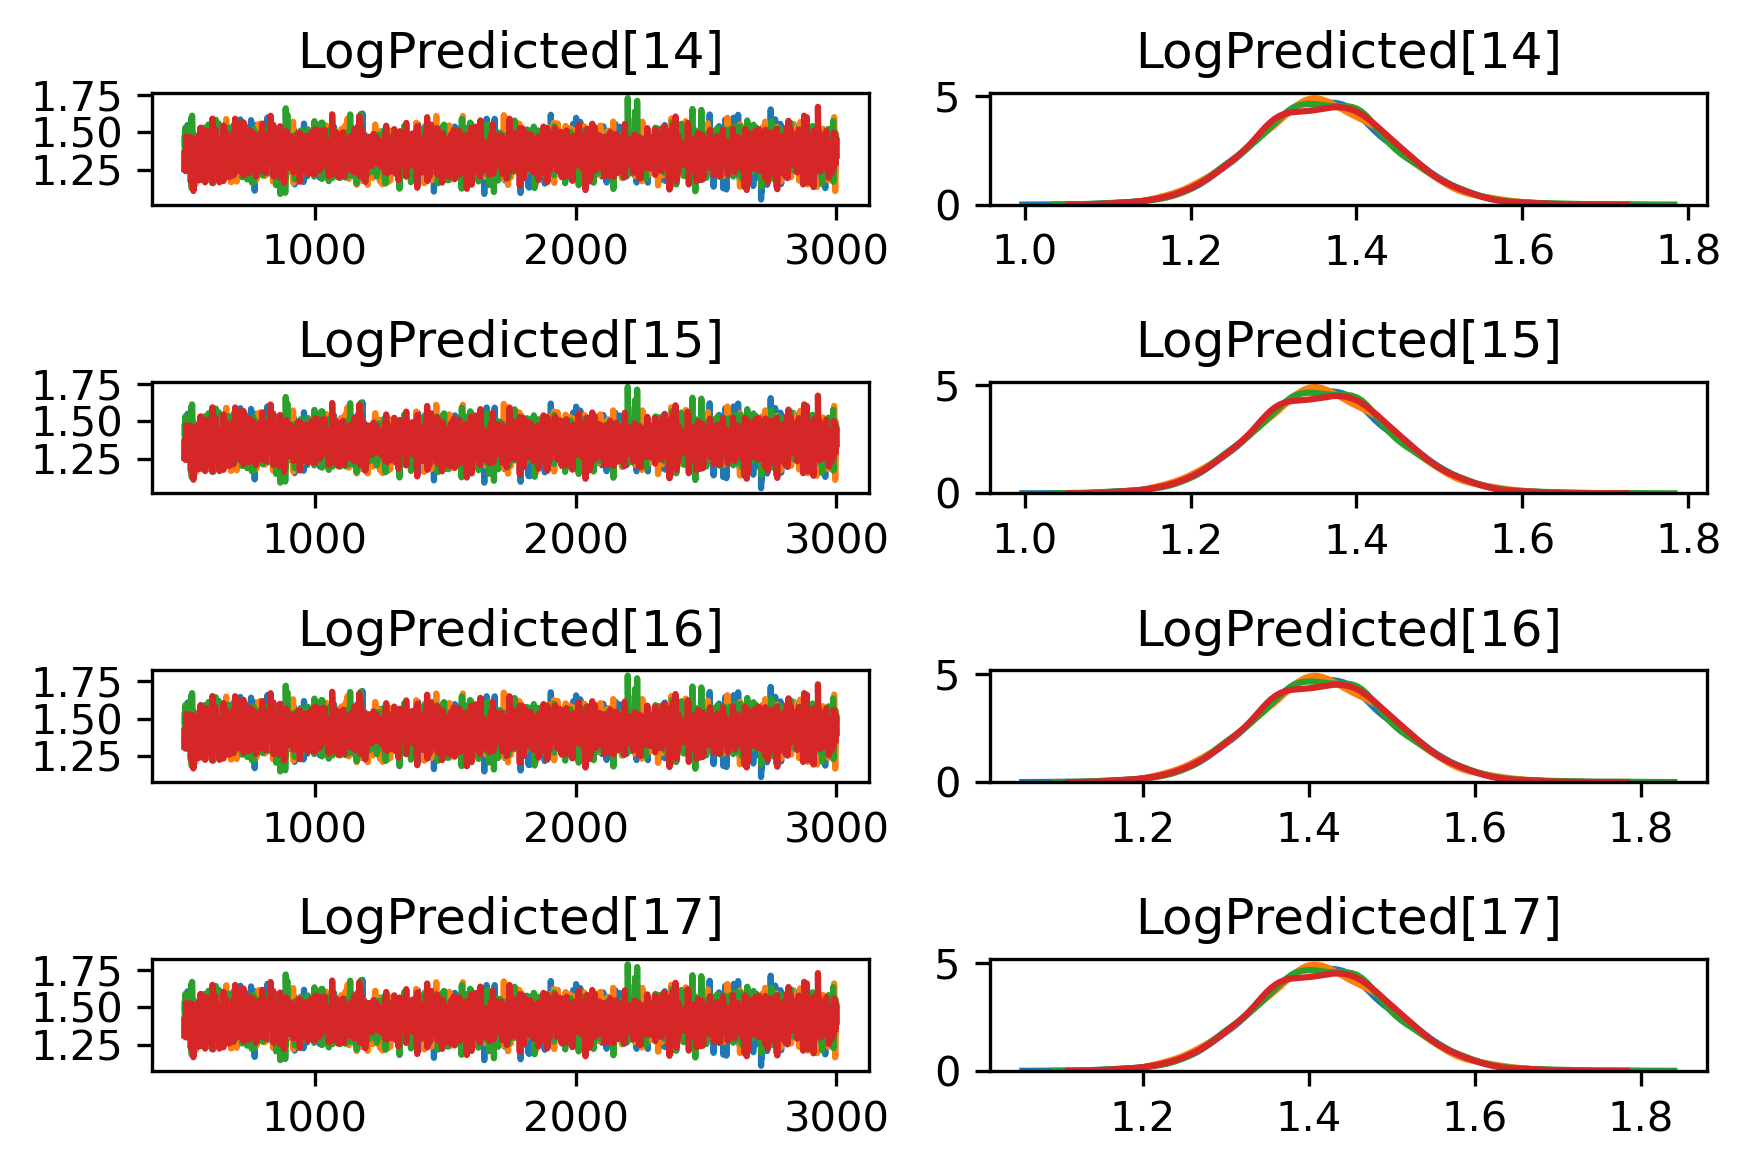

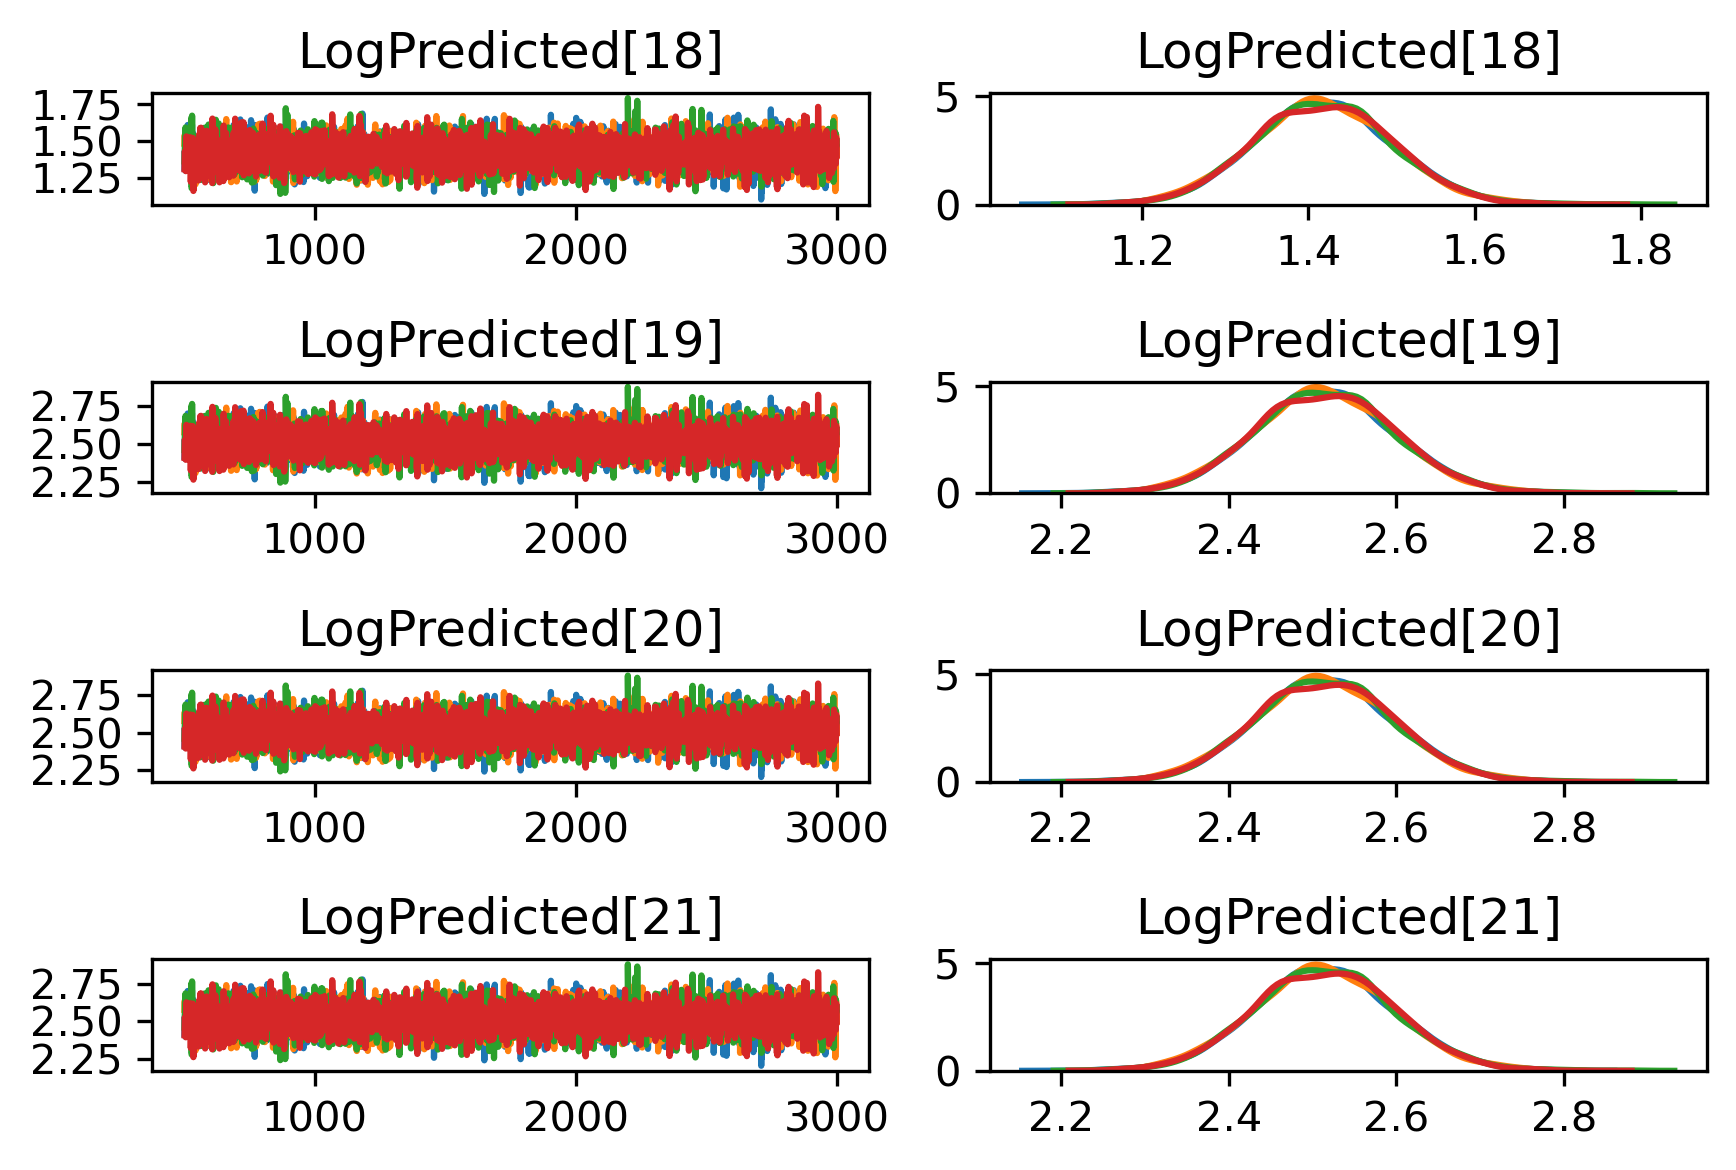

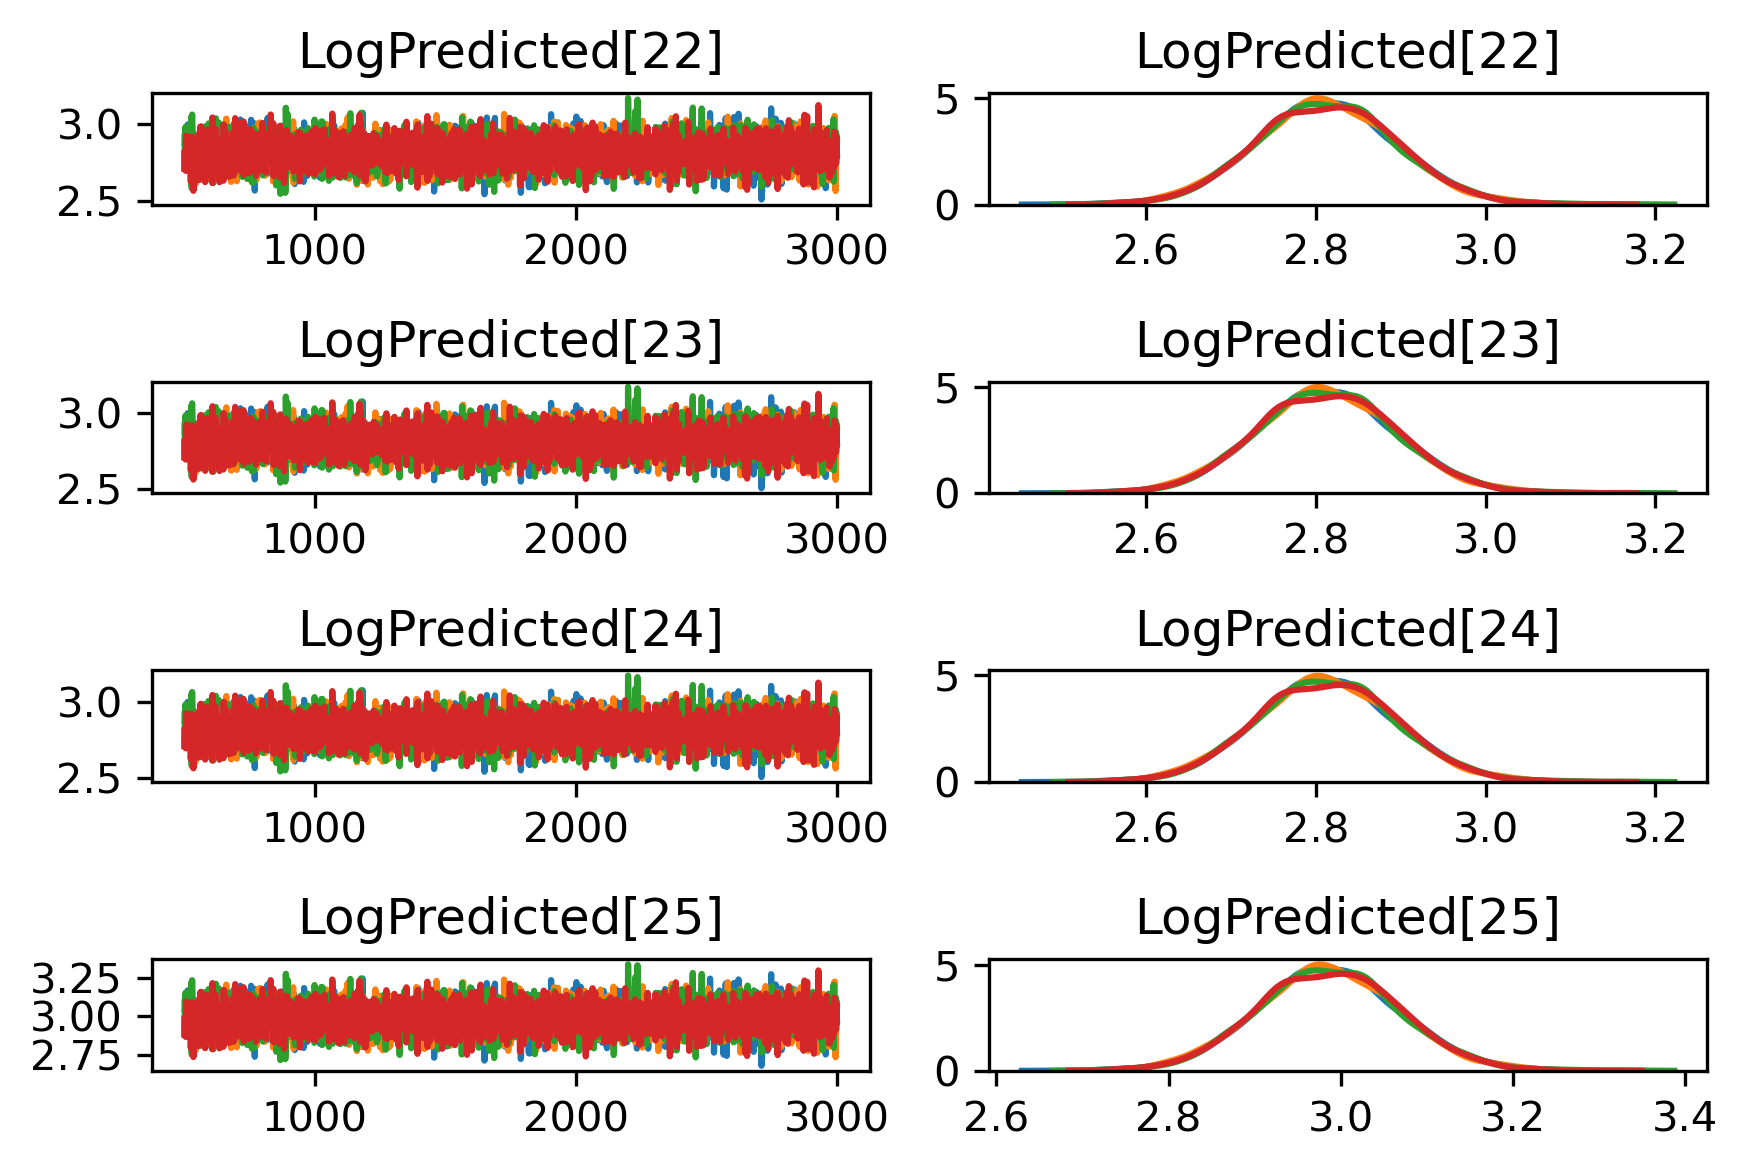

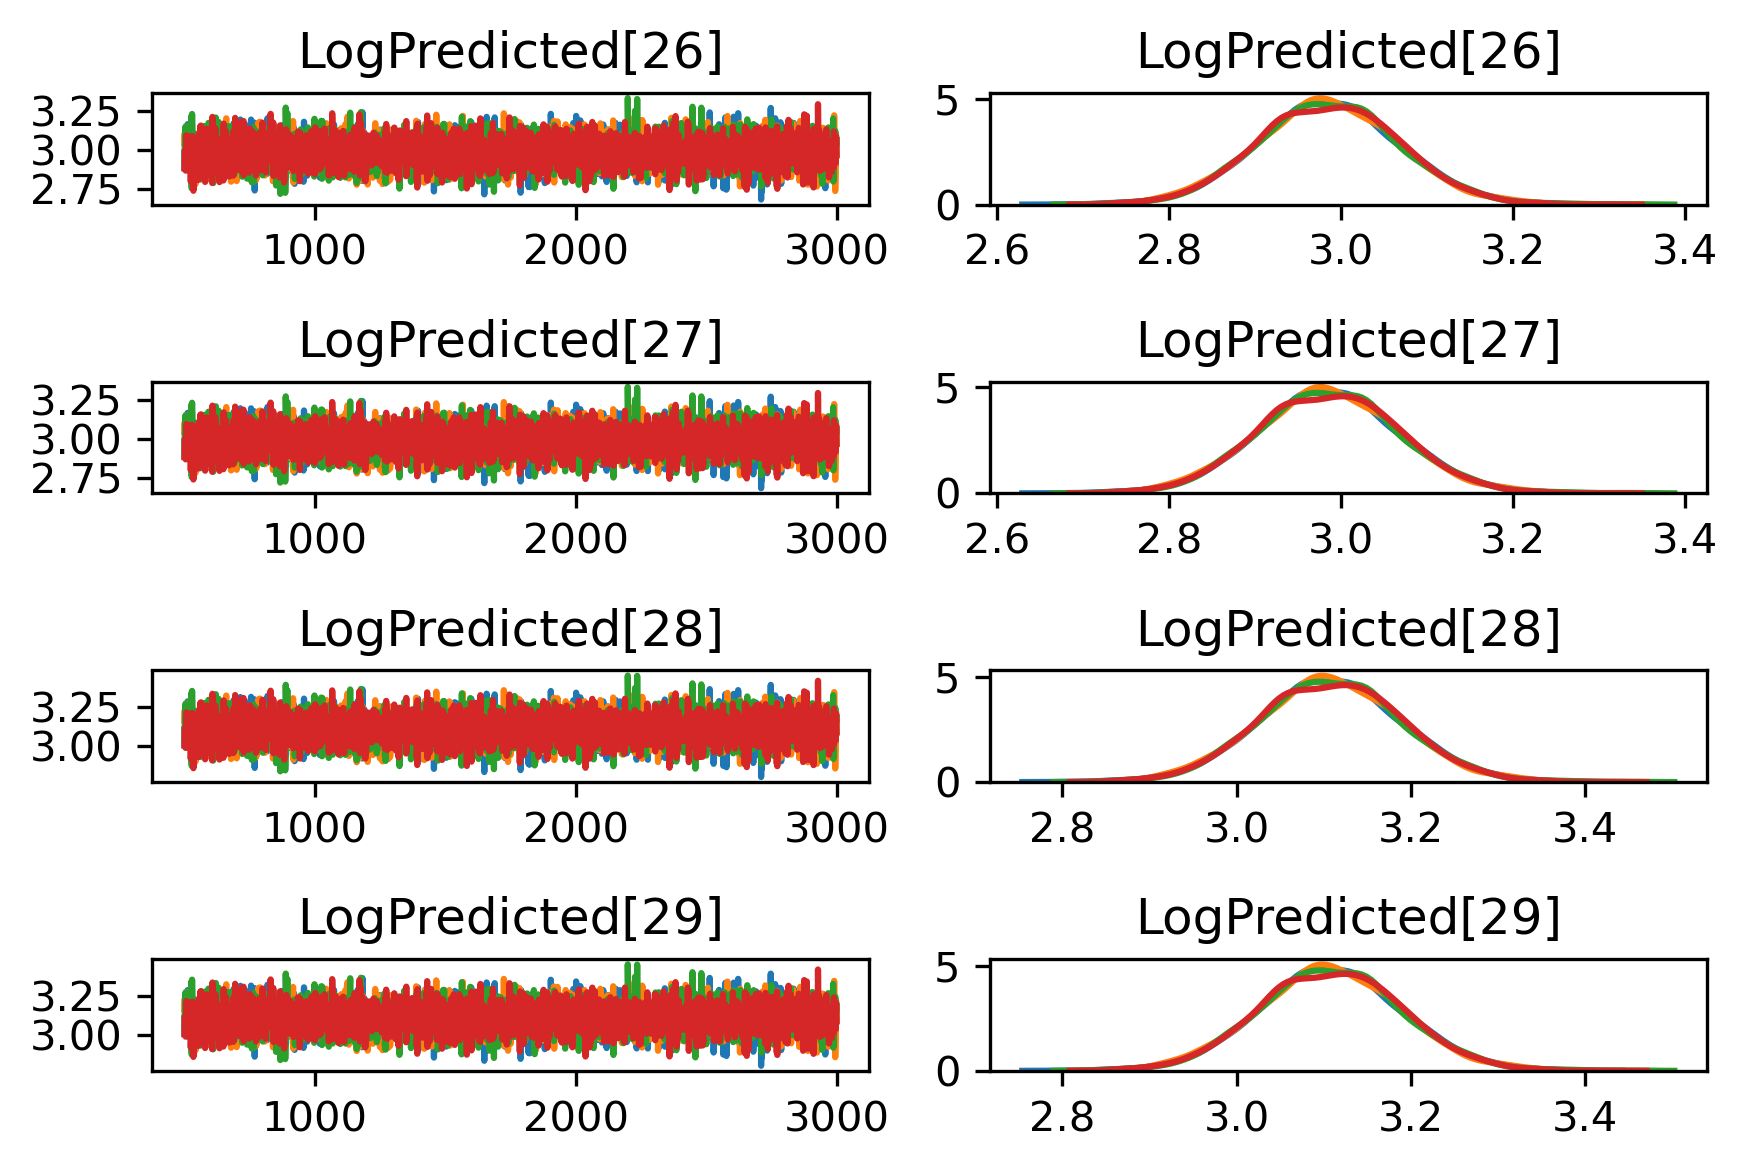

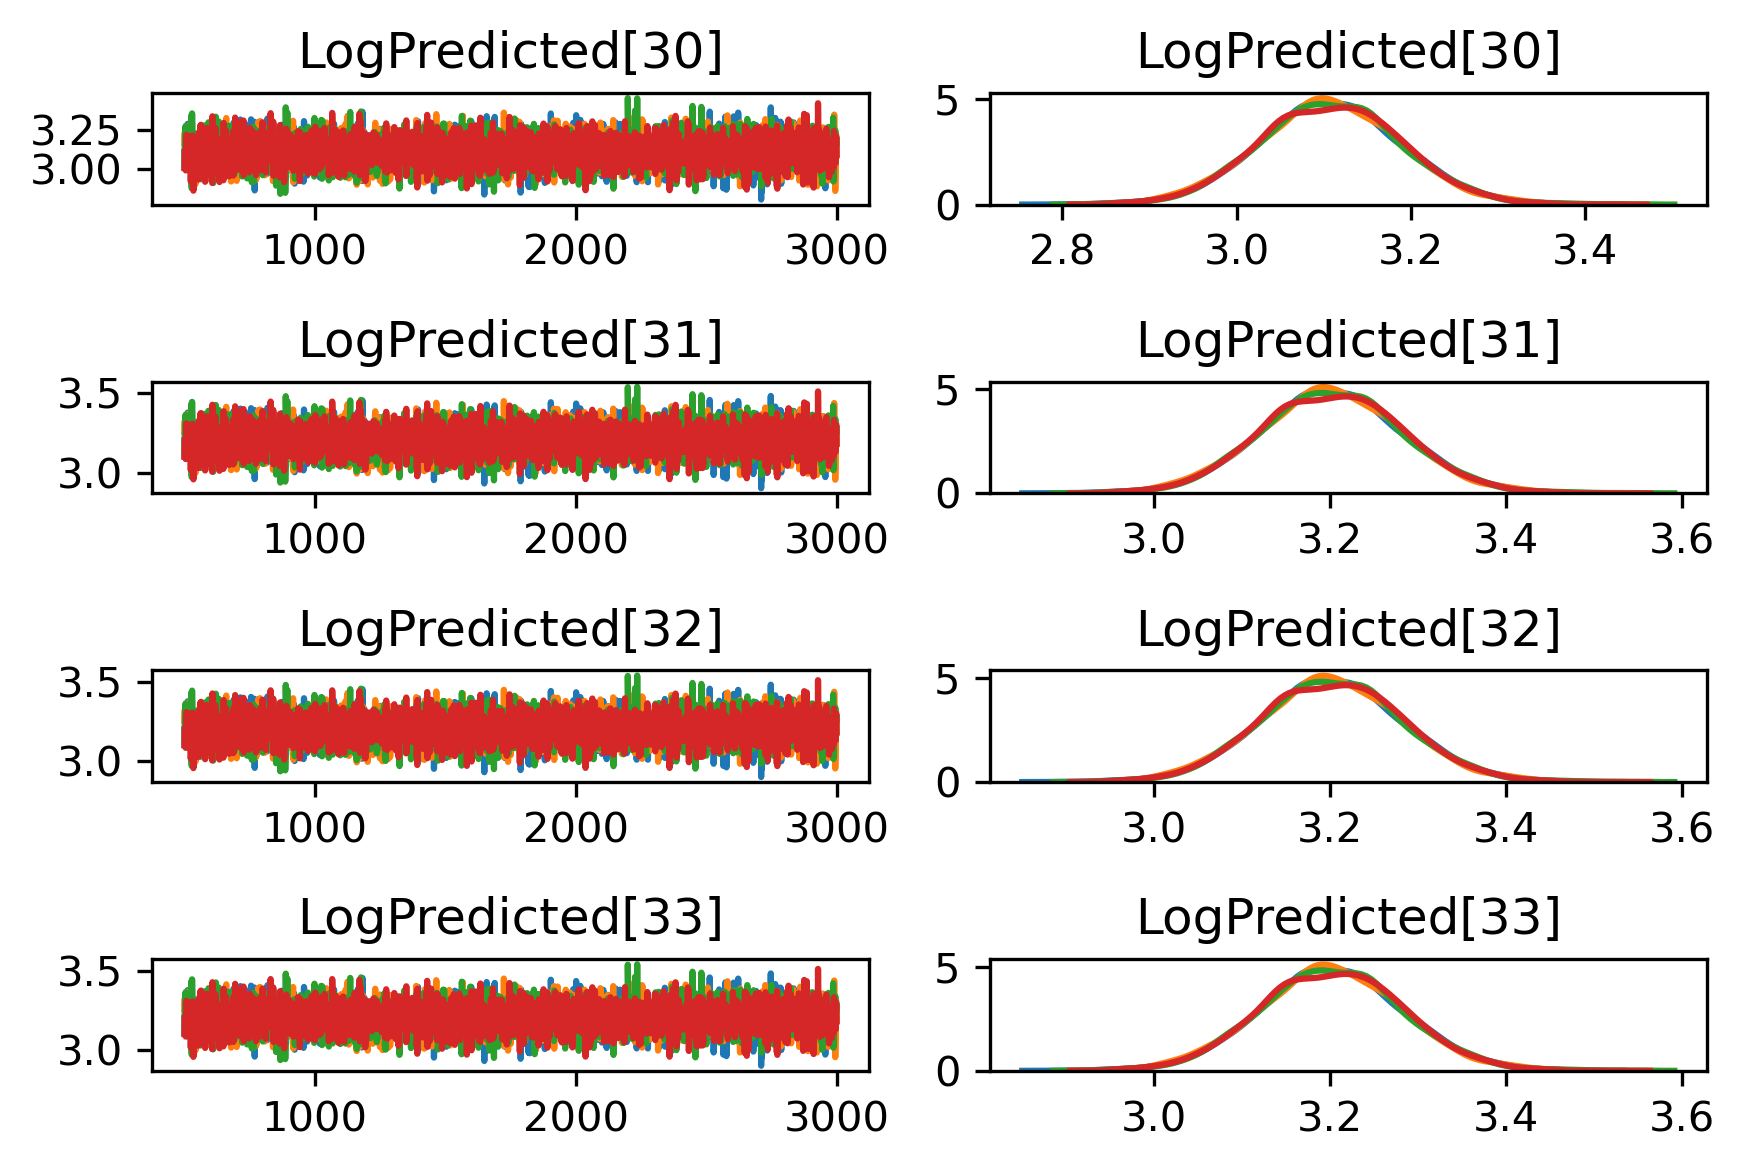

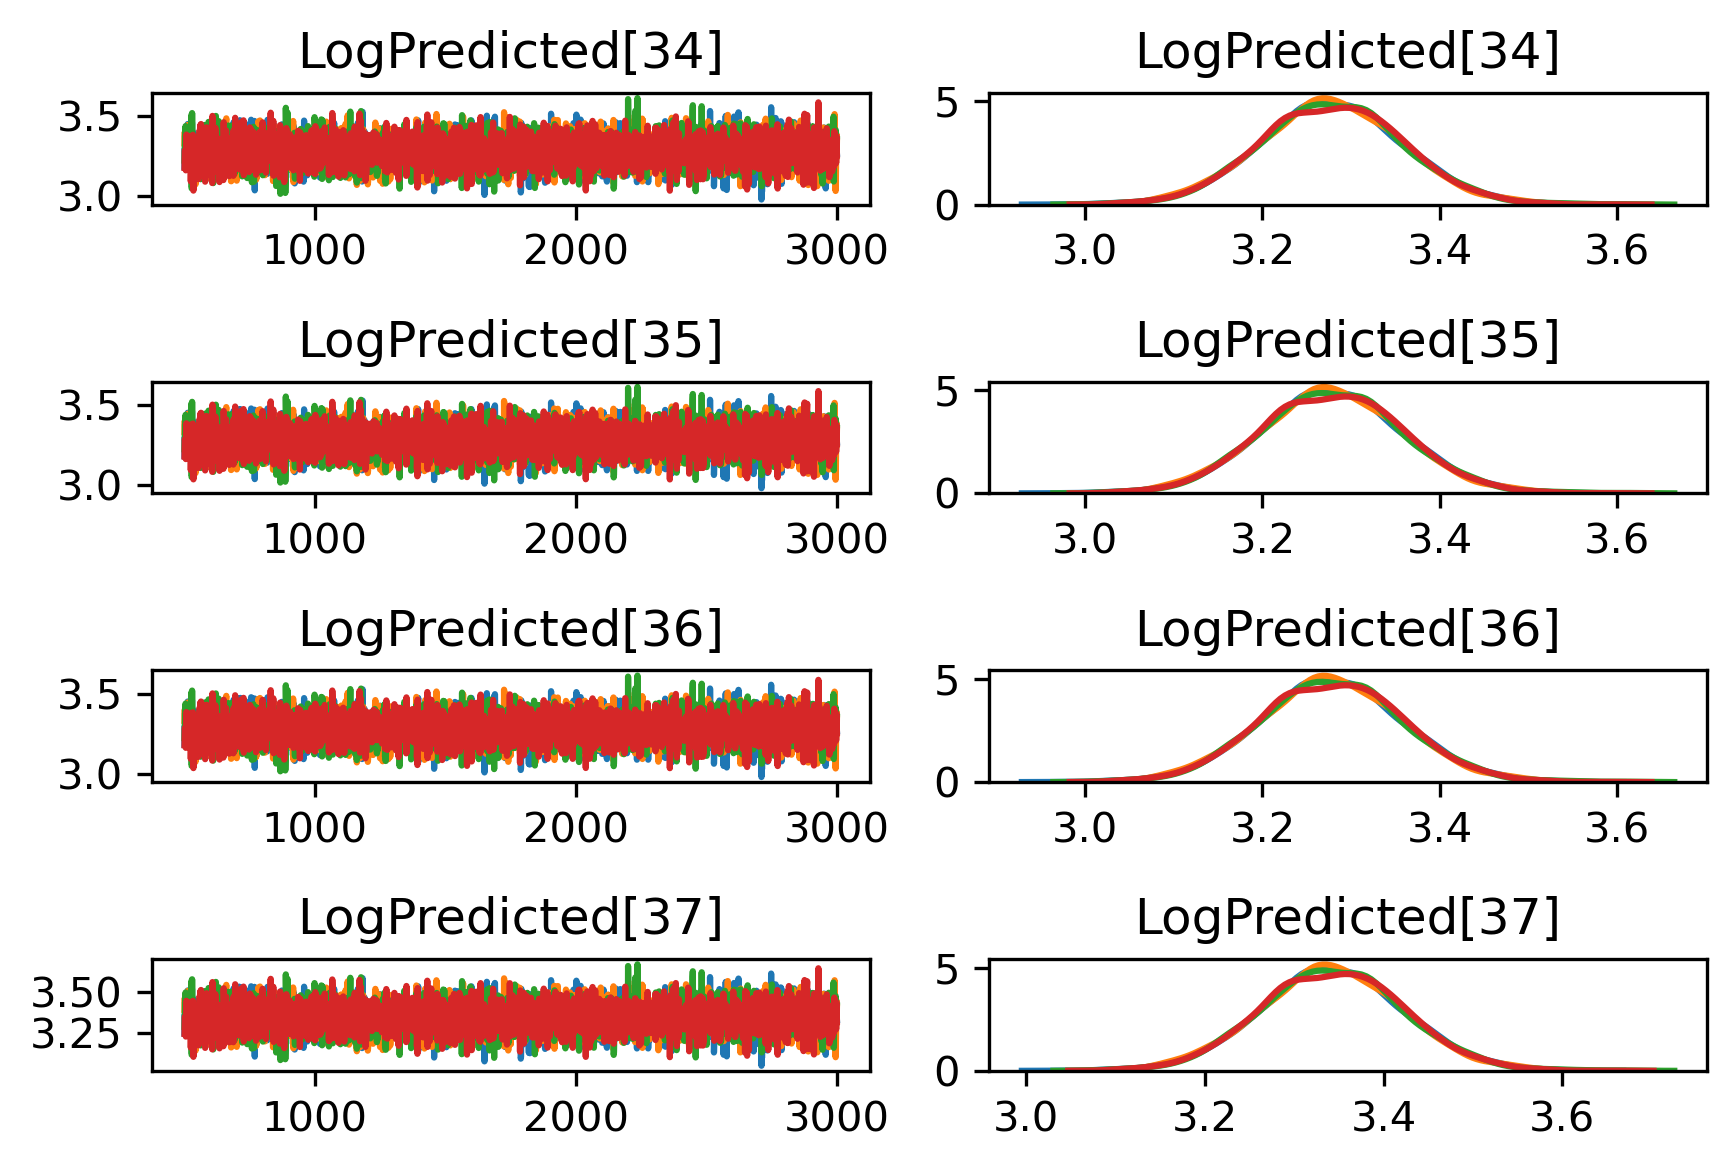

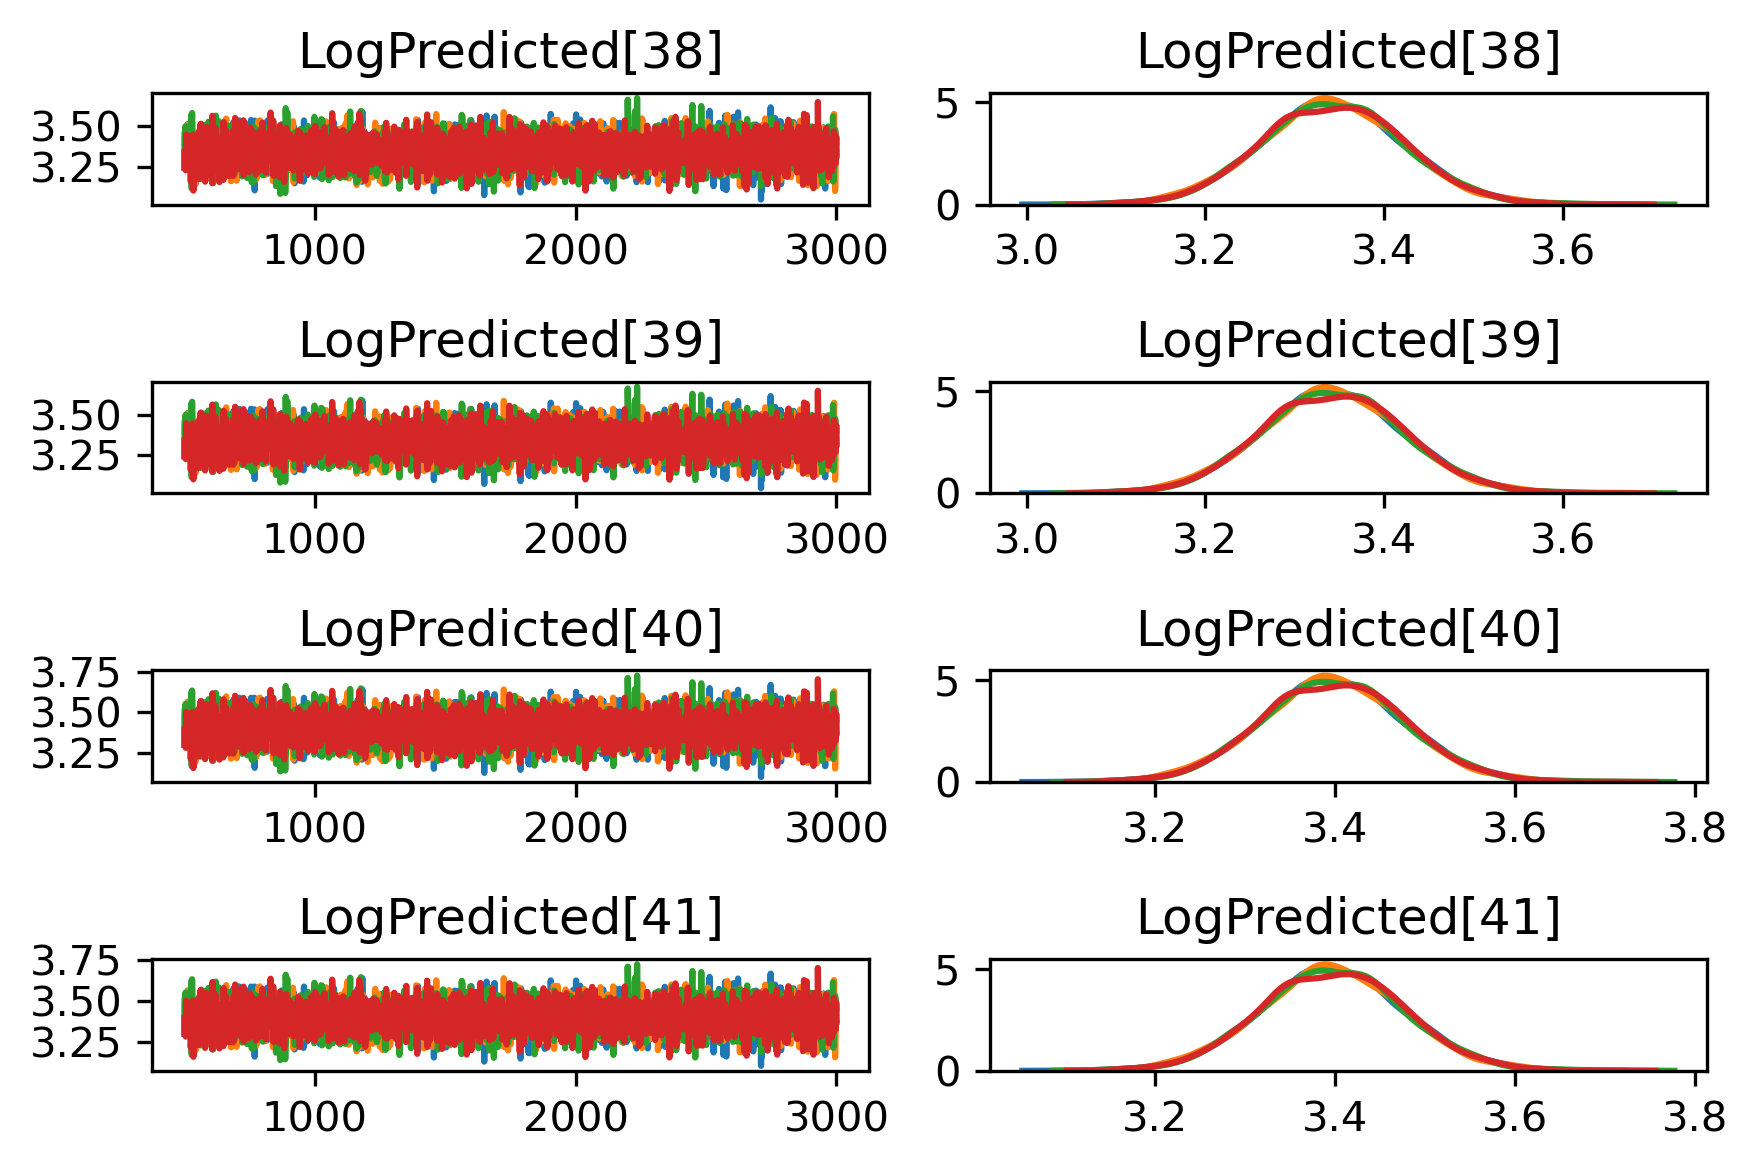

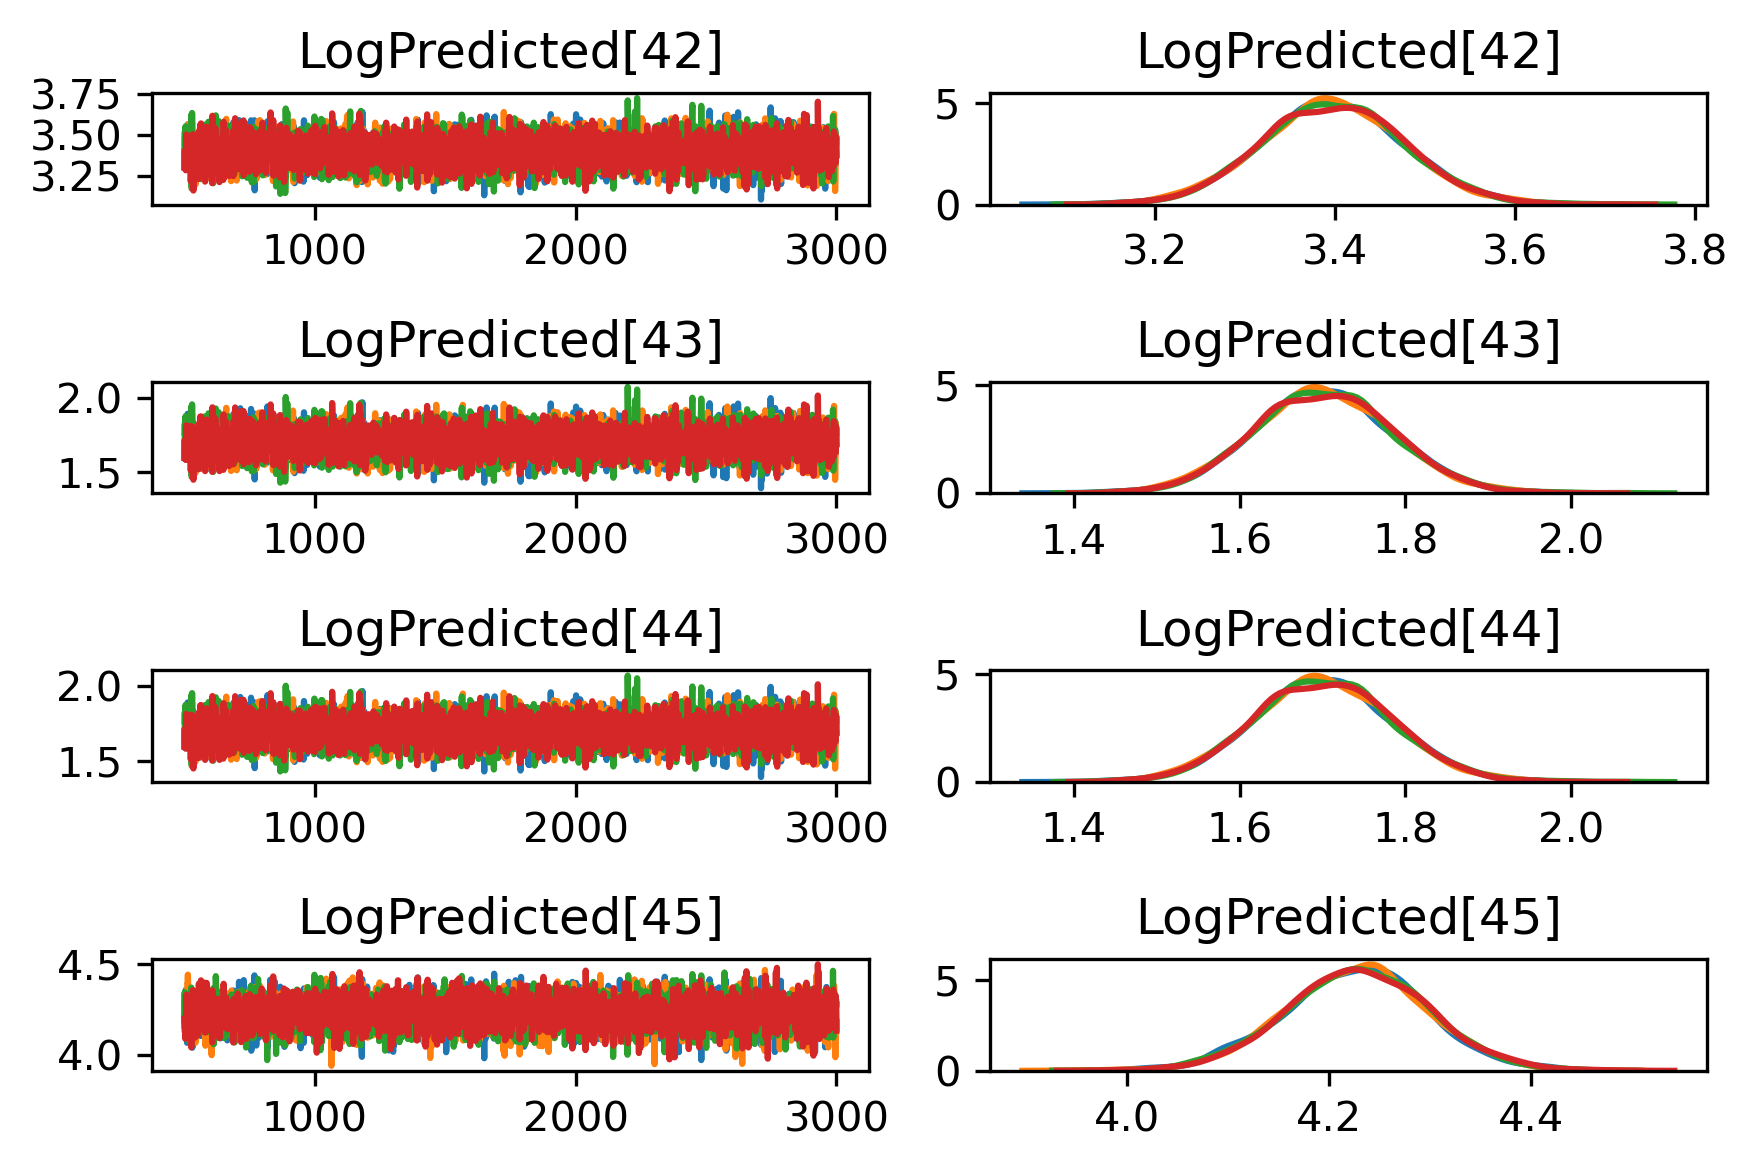

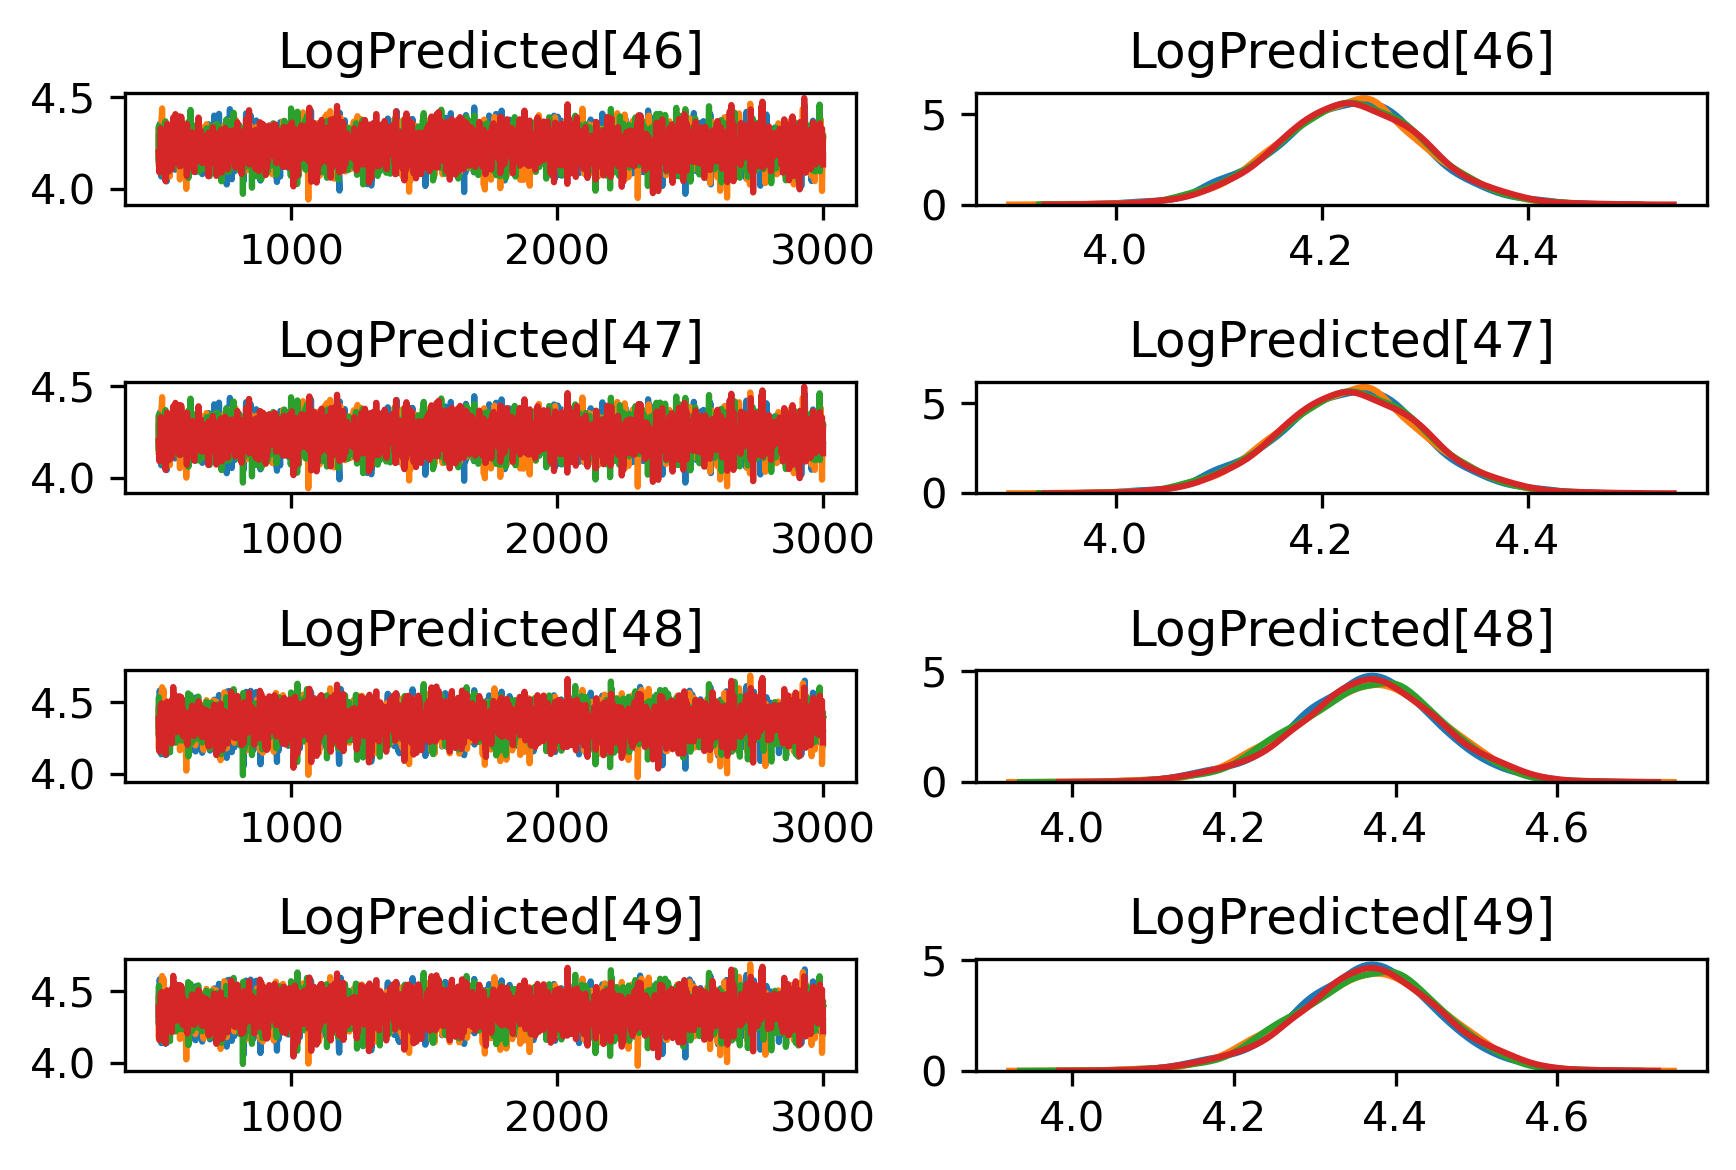

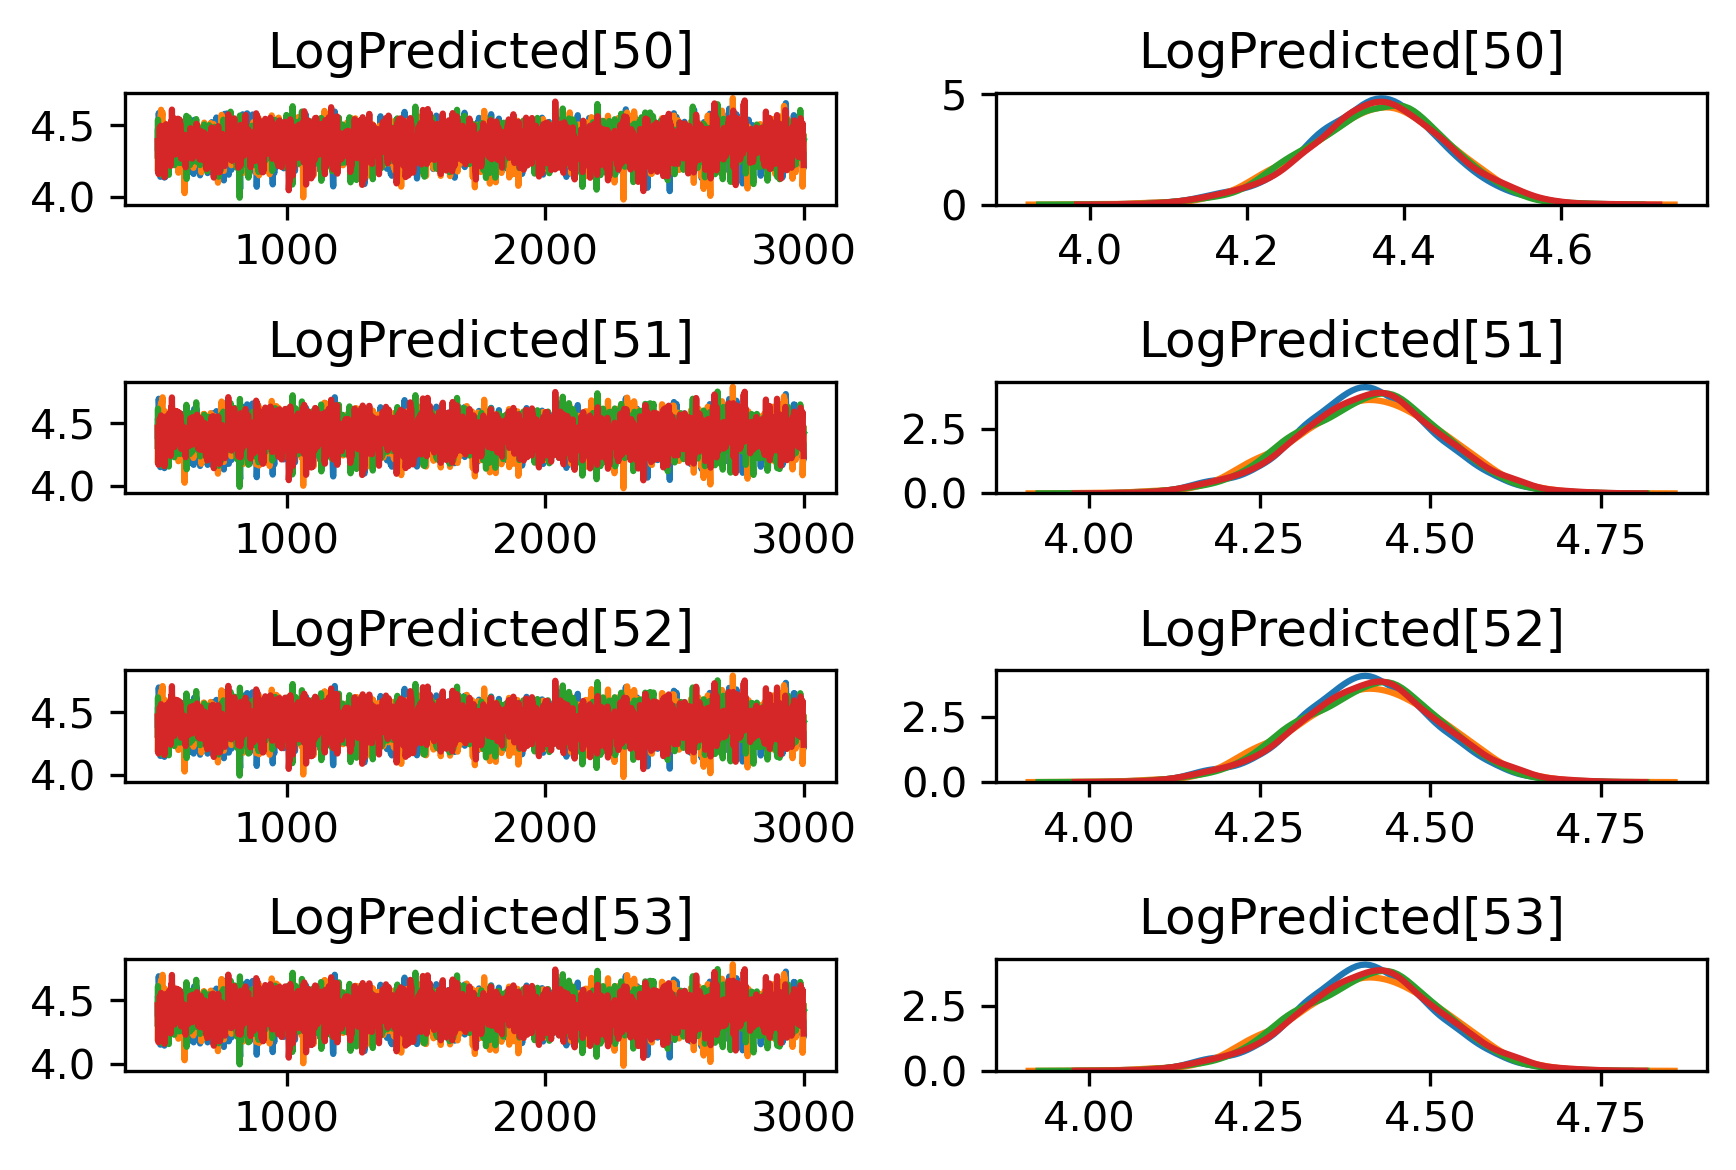

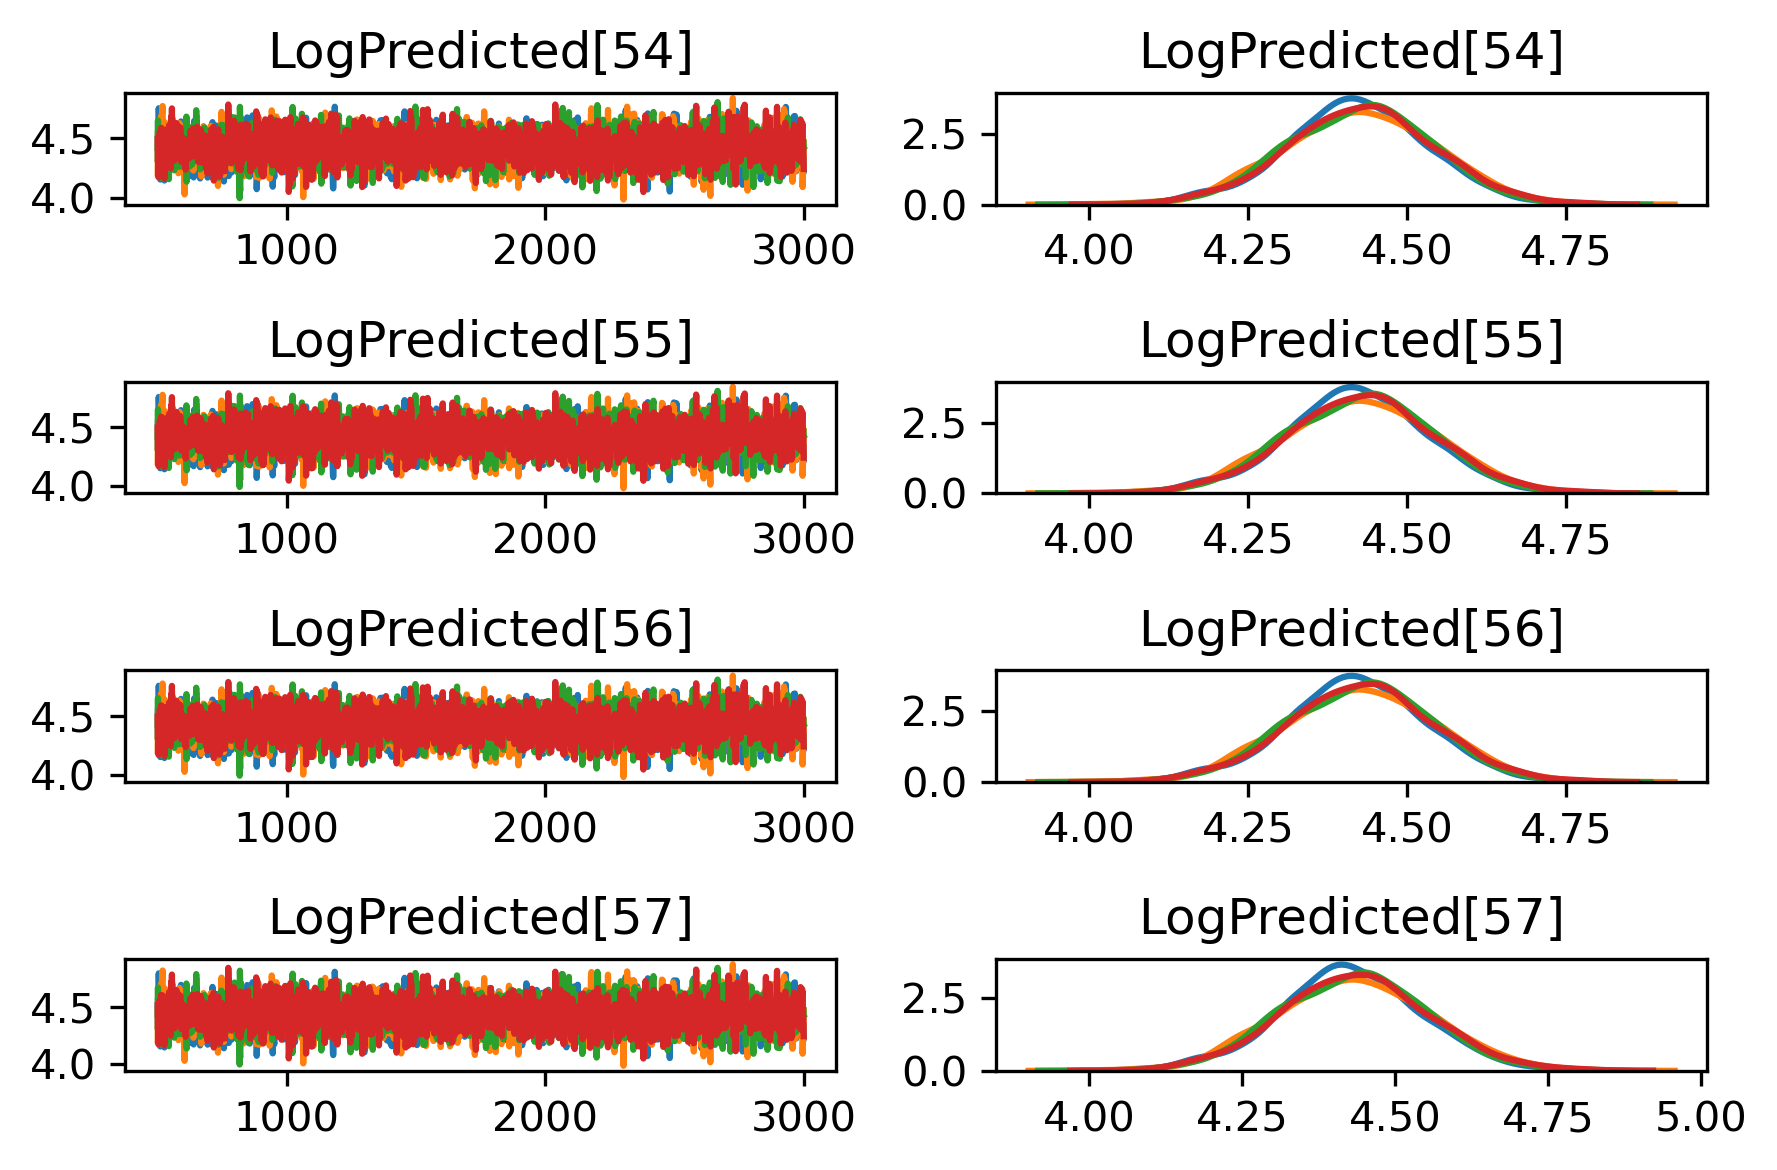

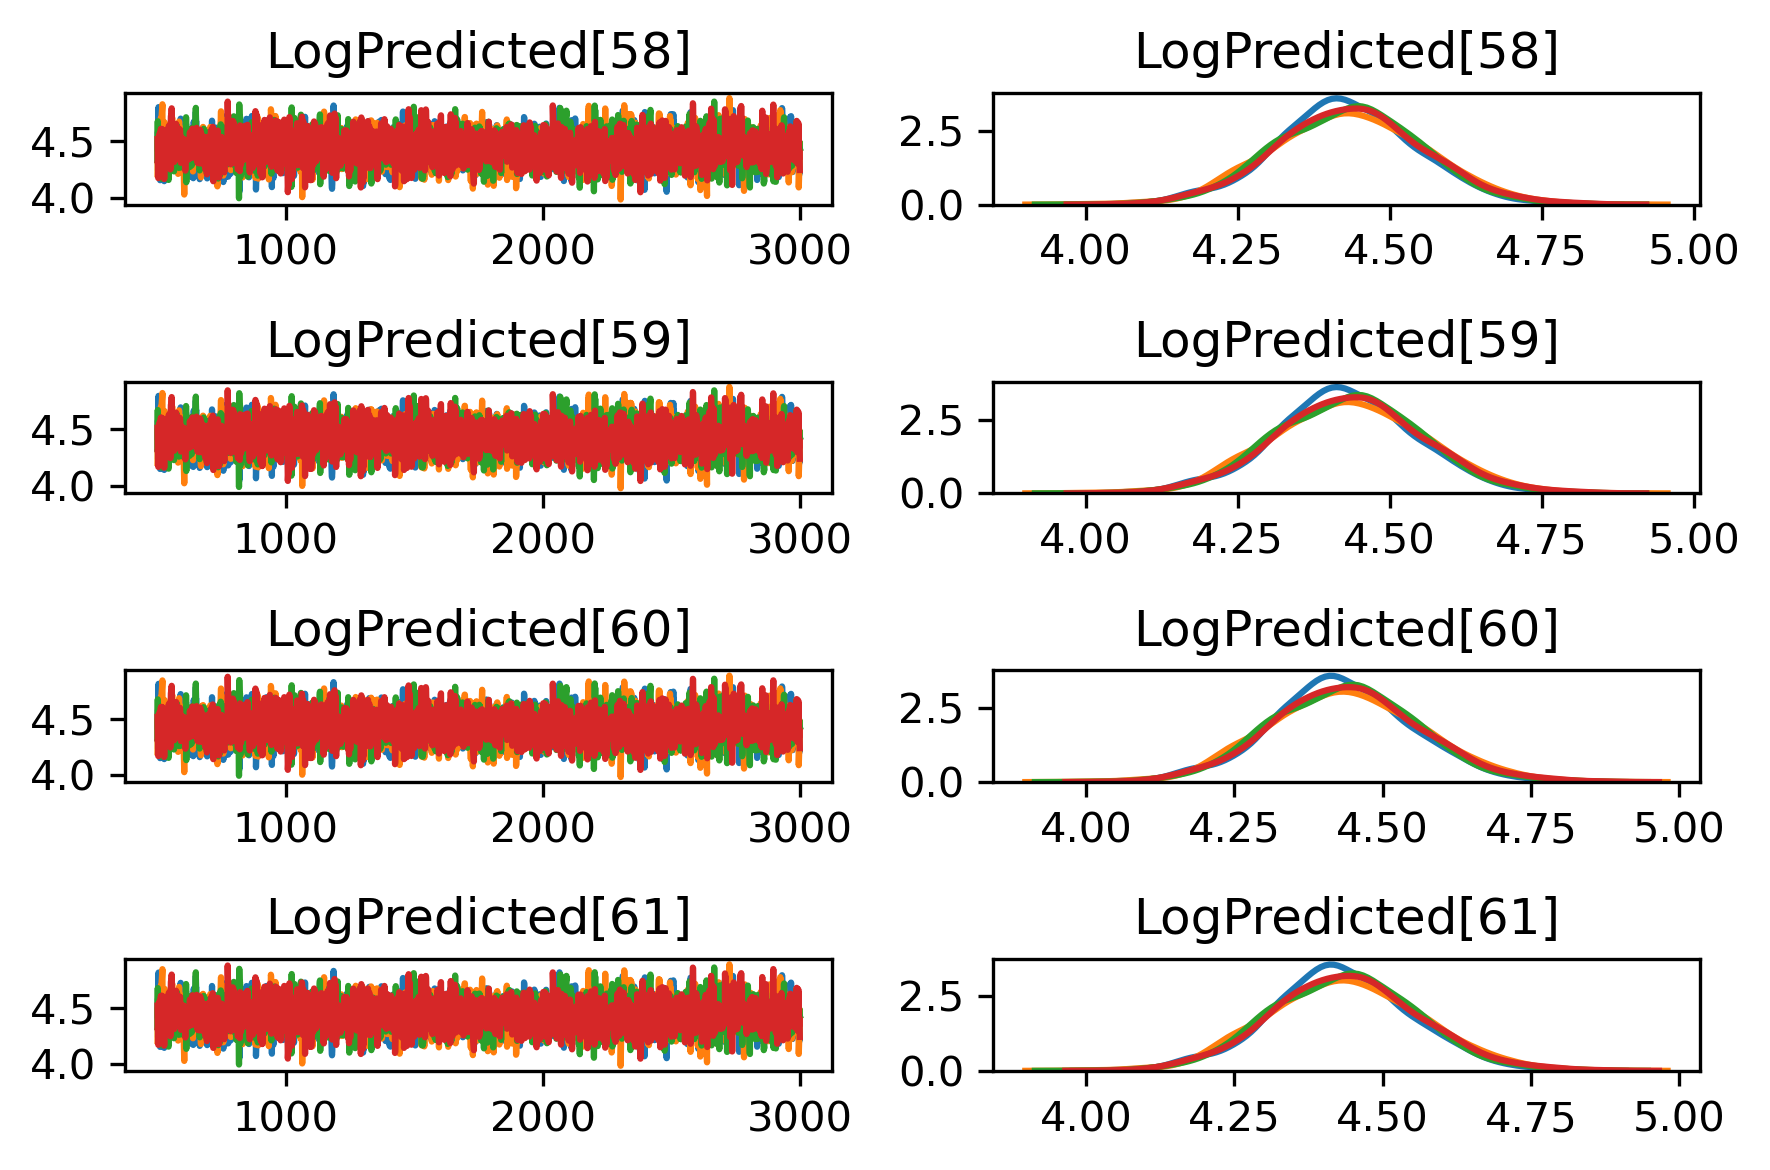

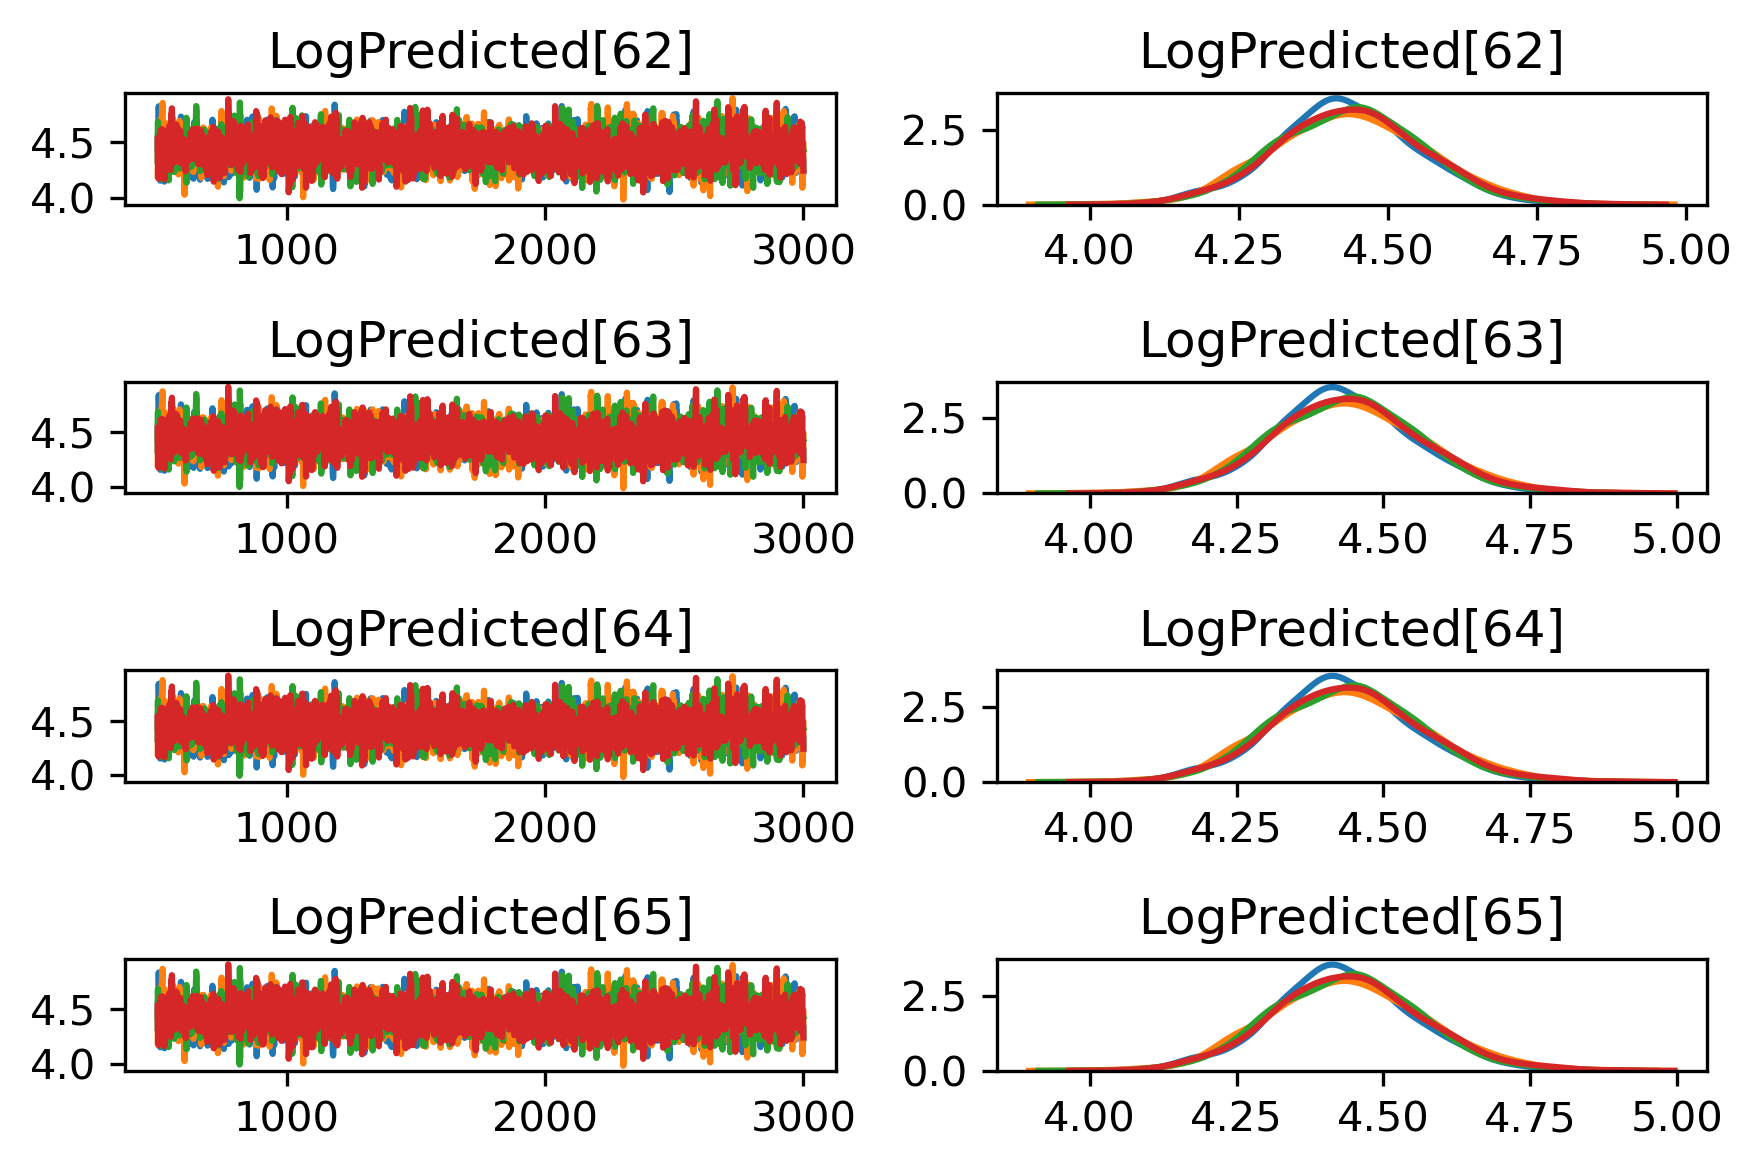

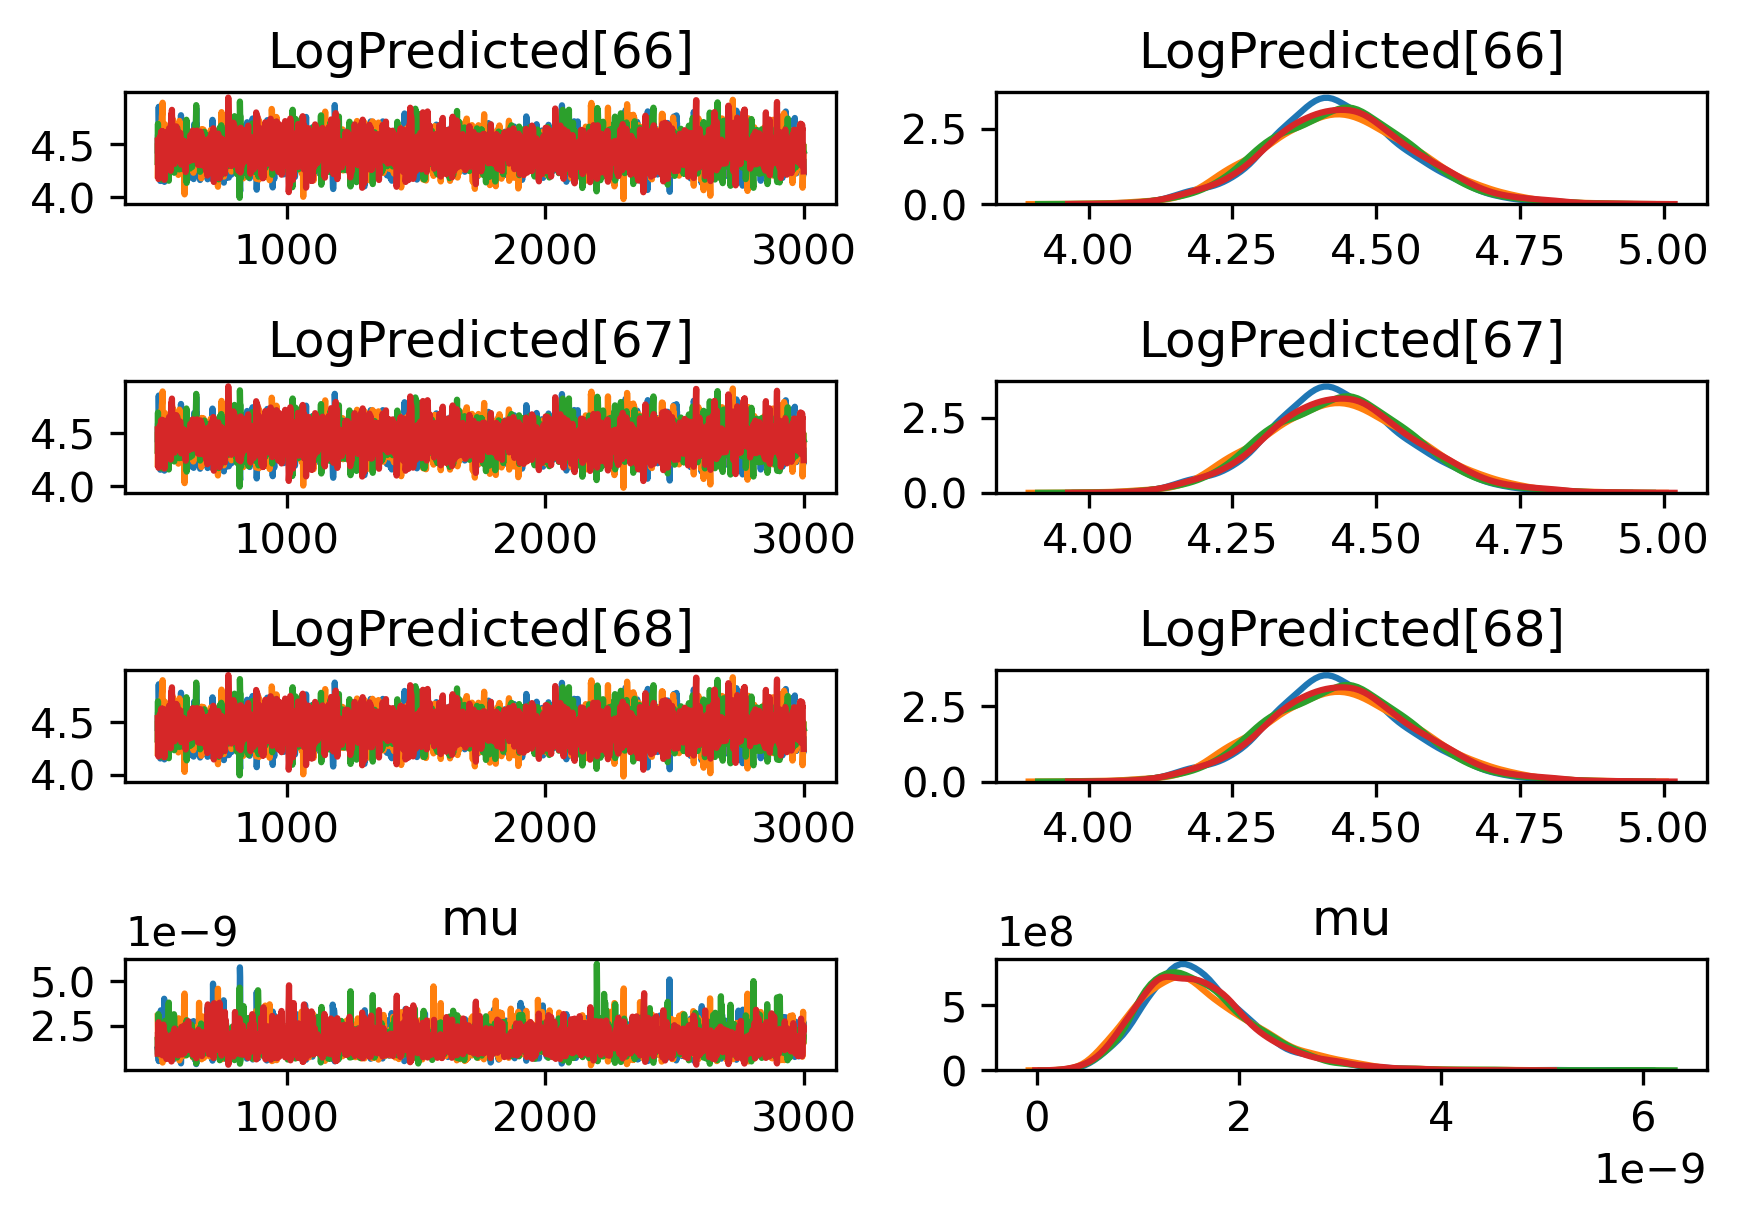

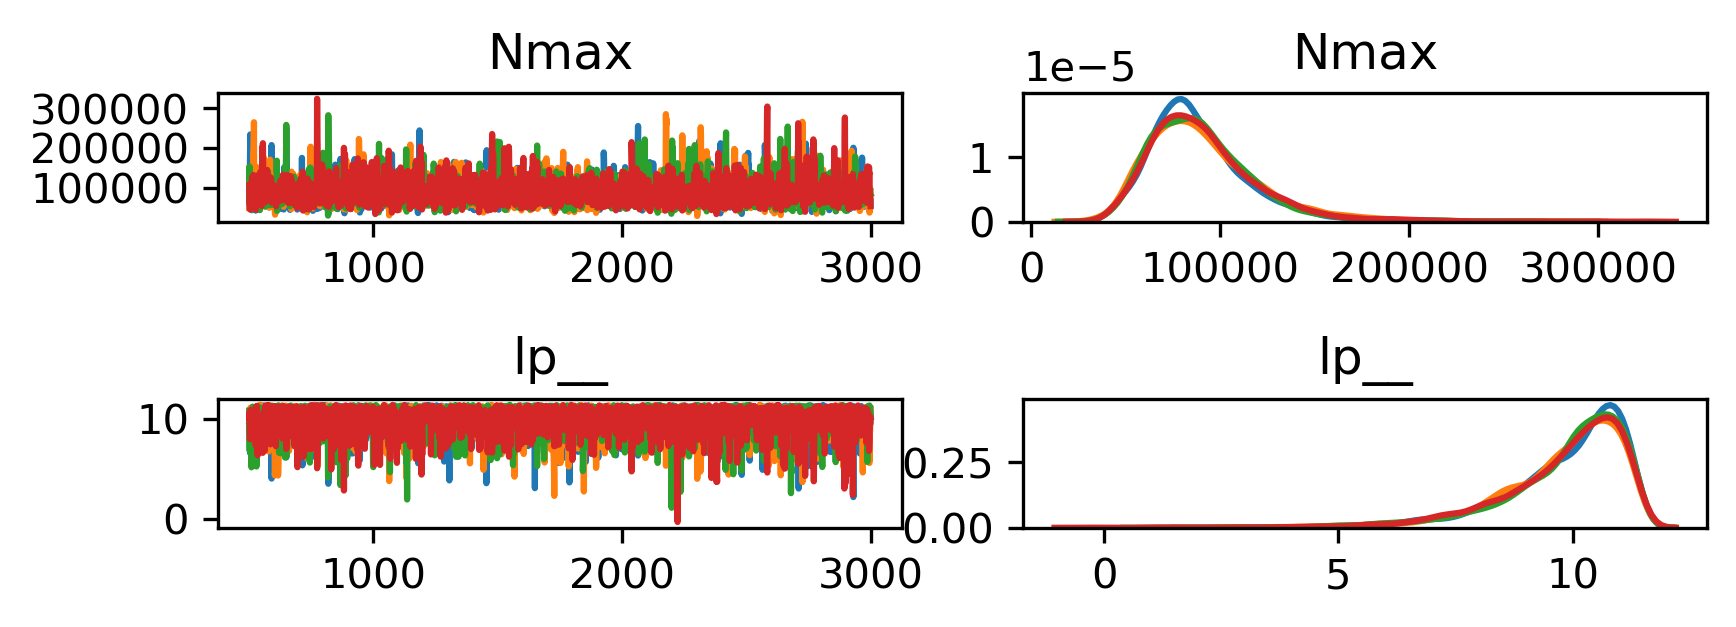

In [5]:
for pg in tqdm(range(num_pages),desc='Progress', leave=False):
    plt.figure(dpi=300)
    pdf = PdfPages("plot/027/Traceplot/Bayesian Fitting Trace"+str(pg)+".pdf")
    for pos in range(4):
        pi = pg*4 + pos
        if pi >= len(paraname): break
        plt.subplot(4, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(4, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
    pdf.savefig()
    pdf.close()
    plt.show()

In [6]:
Class_Time=classification(Time)
name = {}
name[5] = Initial_8
name[4] = Initial_7
name[3] = Initial_6
name[2] = Initial_5
name[1] = Initial_4
name[0] = Initial_3

In [7]:
samples = fit_nuts.extract(permuted=True)
devide = 12*60
time_interval = np.arange(0, np.max(Class_Time)*(devide+1)/devide, np.max(Class_Time)/devide, dtype="float")

Num_mcmc = len(samples["lp__"])


In [8]:
datum_validation = pd.concat([Initial_4, Initial_6, Initial_8])
datum_validation = datum_validation.reset_index()

def Fit_Model(t,LogNdose, LogNmax,Logmu) :
    V = 0.1
    S = 0.32
    Ndose = 10**LogNdose
    Nmax = 10**LogNmax
    mu = 10**Logmu
    return np.log10(V*Ndose*Nmax*S*(np.exp(mu*Ndose*t)-np.exp(mu*Nmax*S*t/V))/(V*Ndose*np.exp(mu*Ndose*t)-Nmax*S*np.exp(mu*Nmax*S*t/V)))
           

y_predict_mcmc = np.zeros((len(datum_validation['Time']),Num_mcmc), dtype=float)
y_predict_quantile = np.zeros((len(datum_validation['Time']),5), dtype=float)
y_predict_count = np.zeros((len(datum_validation['Time']),), dtype=float)
y_predict_residual_square = np.zeros((len(datum_validation['Time']),), dtype=float)
for j in tqdm(range(len(datum_validation.Time)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        mean = (Fit_Model(datum_validation.Time[j],datum_validation.LogDose[j],samples["LogNmax"][k], samples["Logmu"][k]))
        sigma = samples["sigma"][k]
        y_predict_mcmc[j,k] = np.random.normal(mean, sigma)
        
    y_predict_quantile[j,:] =  np.quantile(y_predict_mcmc[j,:],[0.005, 0.025, 0.5, 0.975, 0.995])
    y_predict_count[j] = ( (datum_validation.LogCFU[j] < np.quantile(y_predict_mcmc[j,:], [0.995])) &(datum_validation.LogCFU[j] >= np.quantile(y_predict_mcmc[j,:], [0.005]))).sum()
    y_predict_residual_square[j] = (datum_validation.LogCFU[j] - np.quantile(y_predict_mcmc[j,:], [0.5]))**2


print("Validation data count")
print(len(datum_validation['Time']))
print("Accuracy of 99% predictive range")
print(y_predict_count.sum()/len(datum_validation['Time'])*100)
print("RMSE of median")
print((y_predict_residual_square.sum()/len(datum_validation['Time']))**0.5)


Validation data count
68
Accuracy of 99% predictive range
100.0
RMSE of median
0.7103776068163415


In [9]:
x=np.arange(0, 12, 0.1, dtype="float")

#LogNdose = np.mean(np.log10(Fitting.N0))
LogNmax = st.median(samples["LogNmax"])
#LogNmax = 4.5
sigma = st.median(samples["sigma"])
Logmu = st.median(samples["Logmu"])
#Logmu = 0.0001
Palette=sns.color_palette(n_colors=len(class_LogDose))

In [10]:
def Fit_Model(t,LogNdose, LogNmax,Logmu) :
    return np.log10((10**LogNmax)*(1-np.exp(-1*t*10**(LogNdose+Logmu))))

def Sample_percentile(t,y_mcmc) :
    prob = [0.5,1,2.5,5,20,50,80,95,97.5,99,99.5]
    exam = [str(n) for n in prob]
    d = np.zeros((len(time_interval),len(prob)+1), dtype=float)
    for j in range(len(time_interval)):
        d[j,0] = time_interval[j]
        for i in range(len(prob)):
            d[j,i+1] = np.percentile(y_mcmc.iloc[j,:], prob[i],axis=0)
    d = pd.DataFrame(d,dtype="float",columns=["Time"]+exam)
    return d

def CLEAN_NAN(X):
    cleanedList = [x for x in X if not (math.isnan(x) == True)]
    return cleanedList 

def CFU_MEAN(column):
    Timedata=[]
    for time in range(len(Class_Time)):
        Timedata.append(np.mean((column[column['Time']==Class_Time[time]])["LogCFU"]))
    return Timedata

def CFU_SD(column):
    Timedata=[]
    for time in range(len(Class_Time)):
        if len((column[column['Time']==Class_Time[time]])["LogCFU"])==0:
            Timedata.append(np.nan)
        elif len((column[column['Time']==Class_Time[time]])["LogCFU"])==1:
            Timedata.append(0)
        else:
            Timedata.append(st.stdev((column[column['Time']==Class_Time[time]])["LogCFU"]))
    return Timedata

def Rate_MEAN(column):
    Timedata=[]
    for time in range(len(Class_Time)):
        Timedata.append(np.mean((column[column['Time']==Class_Time[time]])["LogRate"]))
    return Timedata

def Rate_SD(column):
    Timedata=[]
    for time in range(len(Class_Time)):
        if len((column[column['Time']==Class_Time[time]])["LogCFU"])==0:
            Timedata.append(np.nan)
        elif len((column[column['Time']==Class_Time[time]])["LogCFU"])==1:
            Timedata.append(0)
        else:
            Timedata.append(st.stdev((column[column['Time']==Class_Time[time]])["LogRate"]))
    return Timedata

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


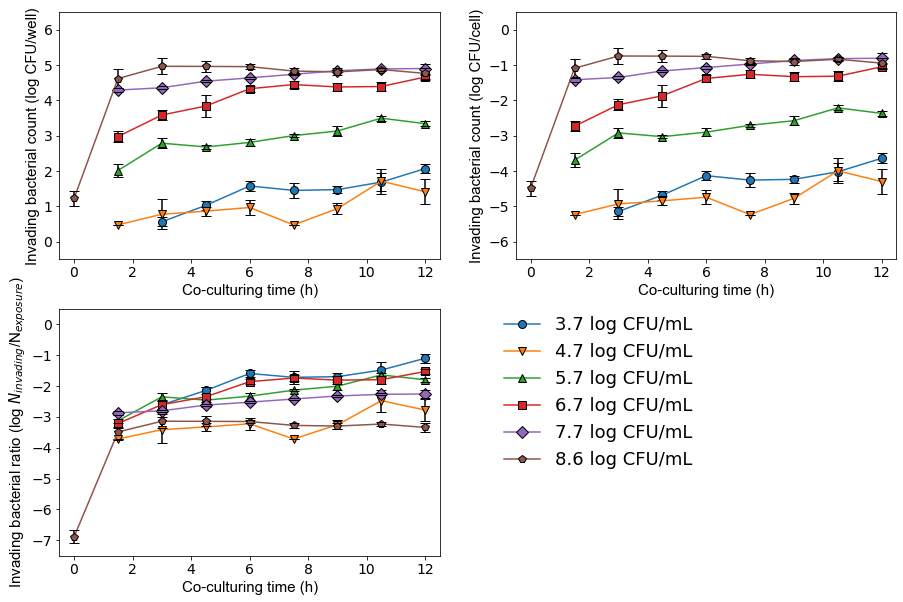

In [11]:
warnings.simplefilter('ignore', RuntimeWarning)
pdf = PdfPages("plot/027/Bacterial Invasion　Bahavior.pdf")
m_shape = ["o", "v", "^", "s", "D", "p"]
plt.figure(1,figsize=(15/2*2,15/3*2))
plt.subplot(2,2,1)
plt.axis([-0.5,12.5,-0.5,6.5],fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel("Invading bacterial count (log CFU/well)",size=15,fontname="Arial")
plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
for i in range(len(class_LogDose)):
    plt.plot(
        Class_Time,CFU_MEAN(name[i]),
        marker=m_shape[i],
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color=Palette[i]
    )
    plt.errorbar(
        Class_Time,CFU_MEAN(name[i]),
        yerr=list(CFU_SD(name[i])),
        fmt="none",
        color="black",
        capsize = 5
    )
plt.subplot(2,2,2)
plt.axis([-0.5,12.5,-6.5,0.5],fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel("Invading bacterial count (log CFU/cell)",size=15,fontname="Arial")
plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
for i in range(len(class_LogDose)):
    plt.plot(
        Class_Time,CFU_MEAN(name[i])-np.log10(510937.5),
        marker=m_shape[i],
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color=Palette[i]
    )
    plt.errorbar(
        Class_Time,CFU_MEAN(name[i])-np.log10(510937.5),
        yerr=list(CFU_SD(name[i])),
        fmt="none",
        color="black",
        capsize = 5
    )
plt.subplot(2,2,3)
plt.axis([-0.5,12.5,-7.5,0.5],fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel("Invading bacterial ratio (log ""$N_{invading}$""/""N$_{exposure}$)",size=15,fontname="Arial")
plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
for i in range(len(class_LogDose)):
    plt.plot(
        Class_Time,Rate_MEAN(name[i]),label=str(round(class_LogDose[i],1))+" log CFU/mL",
        marker=m_shape[i],
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color=Palette[i]
    )
    plt.errorbar(
        Class_Time,Rate_MEAN(name[i]),
        yerr=list(CFU_SD(name[i])),
        fmt="none",
        color="black",
        capsize = 5
    )
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0, fontsize=18,frameon=False)


pdf.savefig()

pdf.close()

plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


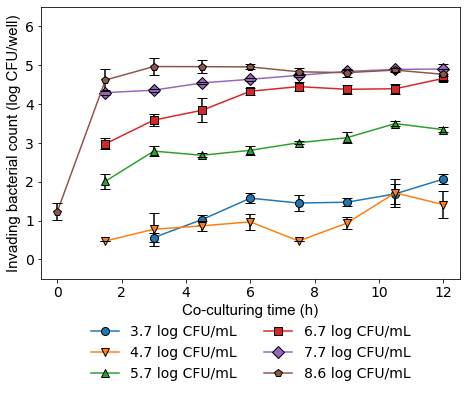

In [12]:
pdf = PdfPages("plot/027/Bacterial Invasion　Count.pdf")
plt.figure(1,figsize=(15/2,15/3))
plt.axis([-0.5,12.5,-0.5,6.5],fontname="Arial")
plt.xticks(size=14)
plt.xticks(np.arange(0, 14, 2))
plt.yticks(size=14)
plt.yticks(np.arange(0, 7, 1))
plt.ylabel("Invading bacterial count (log CFU/well)",size=15,fontname="Arial")
plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
for i in range(len(class_LogDose)):
    plt.plot(
        Class_Time,CFU_MEAN(name[i]),
        marker=m_shape[i],
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color=Palette[i],
        label=str(round(class_LogDose[i],1))+" log CFU/mL"
    )
    plt.errorbar(
        Class_Time,CFU_MEAN(name[i]),
        yerr=list(CFU_SD(name[i])),
        fmt="none",
        color="black",
        capsize = 5
    )
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', borderaxespad=0, fontsize=14, ncol=2, frameon=False)
pdf.savefig(bbox_inches='tight')
pdf.close()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  after removing the cwd from sys.path.


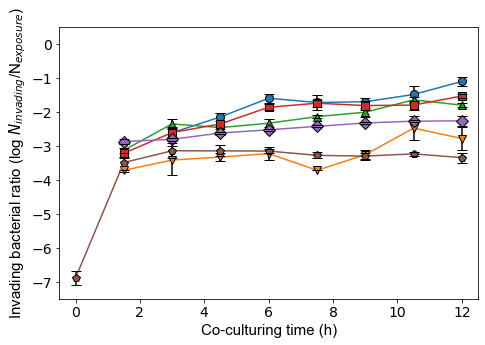

In [13]:
pdf = PdfPages("plot/027/Bacterial Invasion　Ratio.pdf")
plt.figure(1,figsize=(15/2,15/3))

plt.axis([-0.5,12.5,-7.5,0.5],fontname="Arial")
plt.xticks(size=14)
plt.xticks(np.arange(0, 14, 2))
plt.yticks(size=14)
plt.yticks(np.arange(-7, 1, 1))
plt.ylabel("Invading bacterial ratio (log ""$N_{invading}$""/""N$_{exposure}$)",size=15,fontname="Arial")
plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
for i in range(len(class_LogDose)):
    plt.plot(
        Class_Time,Rate_MEAN(name[i]),label=str(round(class_LogDose[i],1))+" log CFU/mL",
        marker=m_shape[i],
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color=Palette[i]
    )
    plt.errorbar(
        Class_Time,Rate_MEAN(name[i]),
        yerr=list(CFU_SD(name[i])),
        fmt="none",
        color="black",
        capsize = 5
    )

pdf.savefig(bbox_inches='tight')
pdf.close()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/lib/python3.

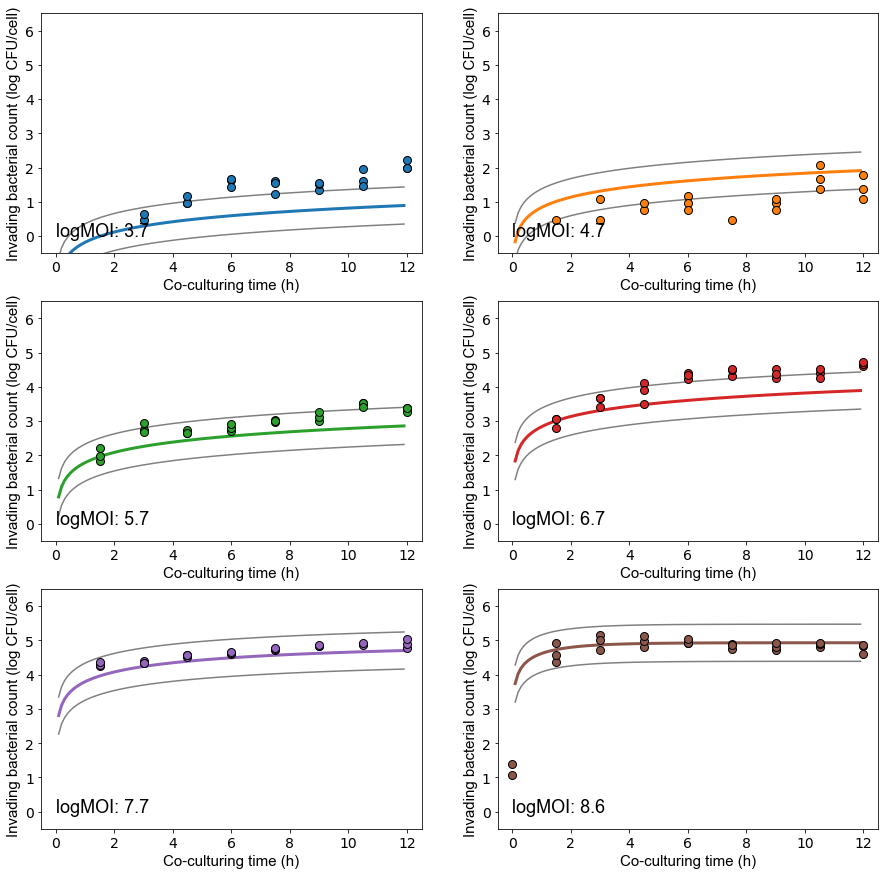

In [14]:
pdf = PdfPages("plot/027/Bayesian Fitted Bacterial Invasion per cell.pdf")

plt.figure(1,figsize=(15,15))

for i in range(len(class_LogDose)):
    plt.subplot(3,2,i+1)
    plt.ylabel("Invading bacterial count (log CFU/cell)",size=15,fontname="Arial")
    plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
    plt.text(0,0,"logMOI: "+str(round(class_LogDose[i],1)),size=18,fontname="Arial")
    plt.axis([-0.5,12.5,-0.5,6.5],fontname="Arial")
    plt.xticks(size=14)
    plt.yticks(size=14)
    LogNdose = class_LogDose[i]
    plt.plot(x,Fit_Model(x,LogNdose, LogNmax,Logmu)+sigma,color="gray")
    plt.plot(x,Fit_Model(x,LogNdose, LogNmax,Logmu)-sigma,color="gray")
    plt.plot(x,Fit_Model(x,LogNdose, LogNmax,Logmu),color=Palette[i],linewidth=3)
    plt.plot(
        name[i]["Time"],np.log10(name[i]["CFU"]),
        marker="o",
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color="None"
    )

plt.subplots_adjust(wspace=0.2,hspace=0.2)
    

pdf.savefig(bbox_inches='tight')

pdf.close()

plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


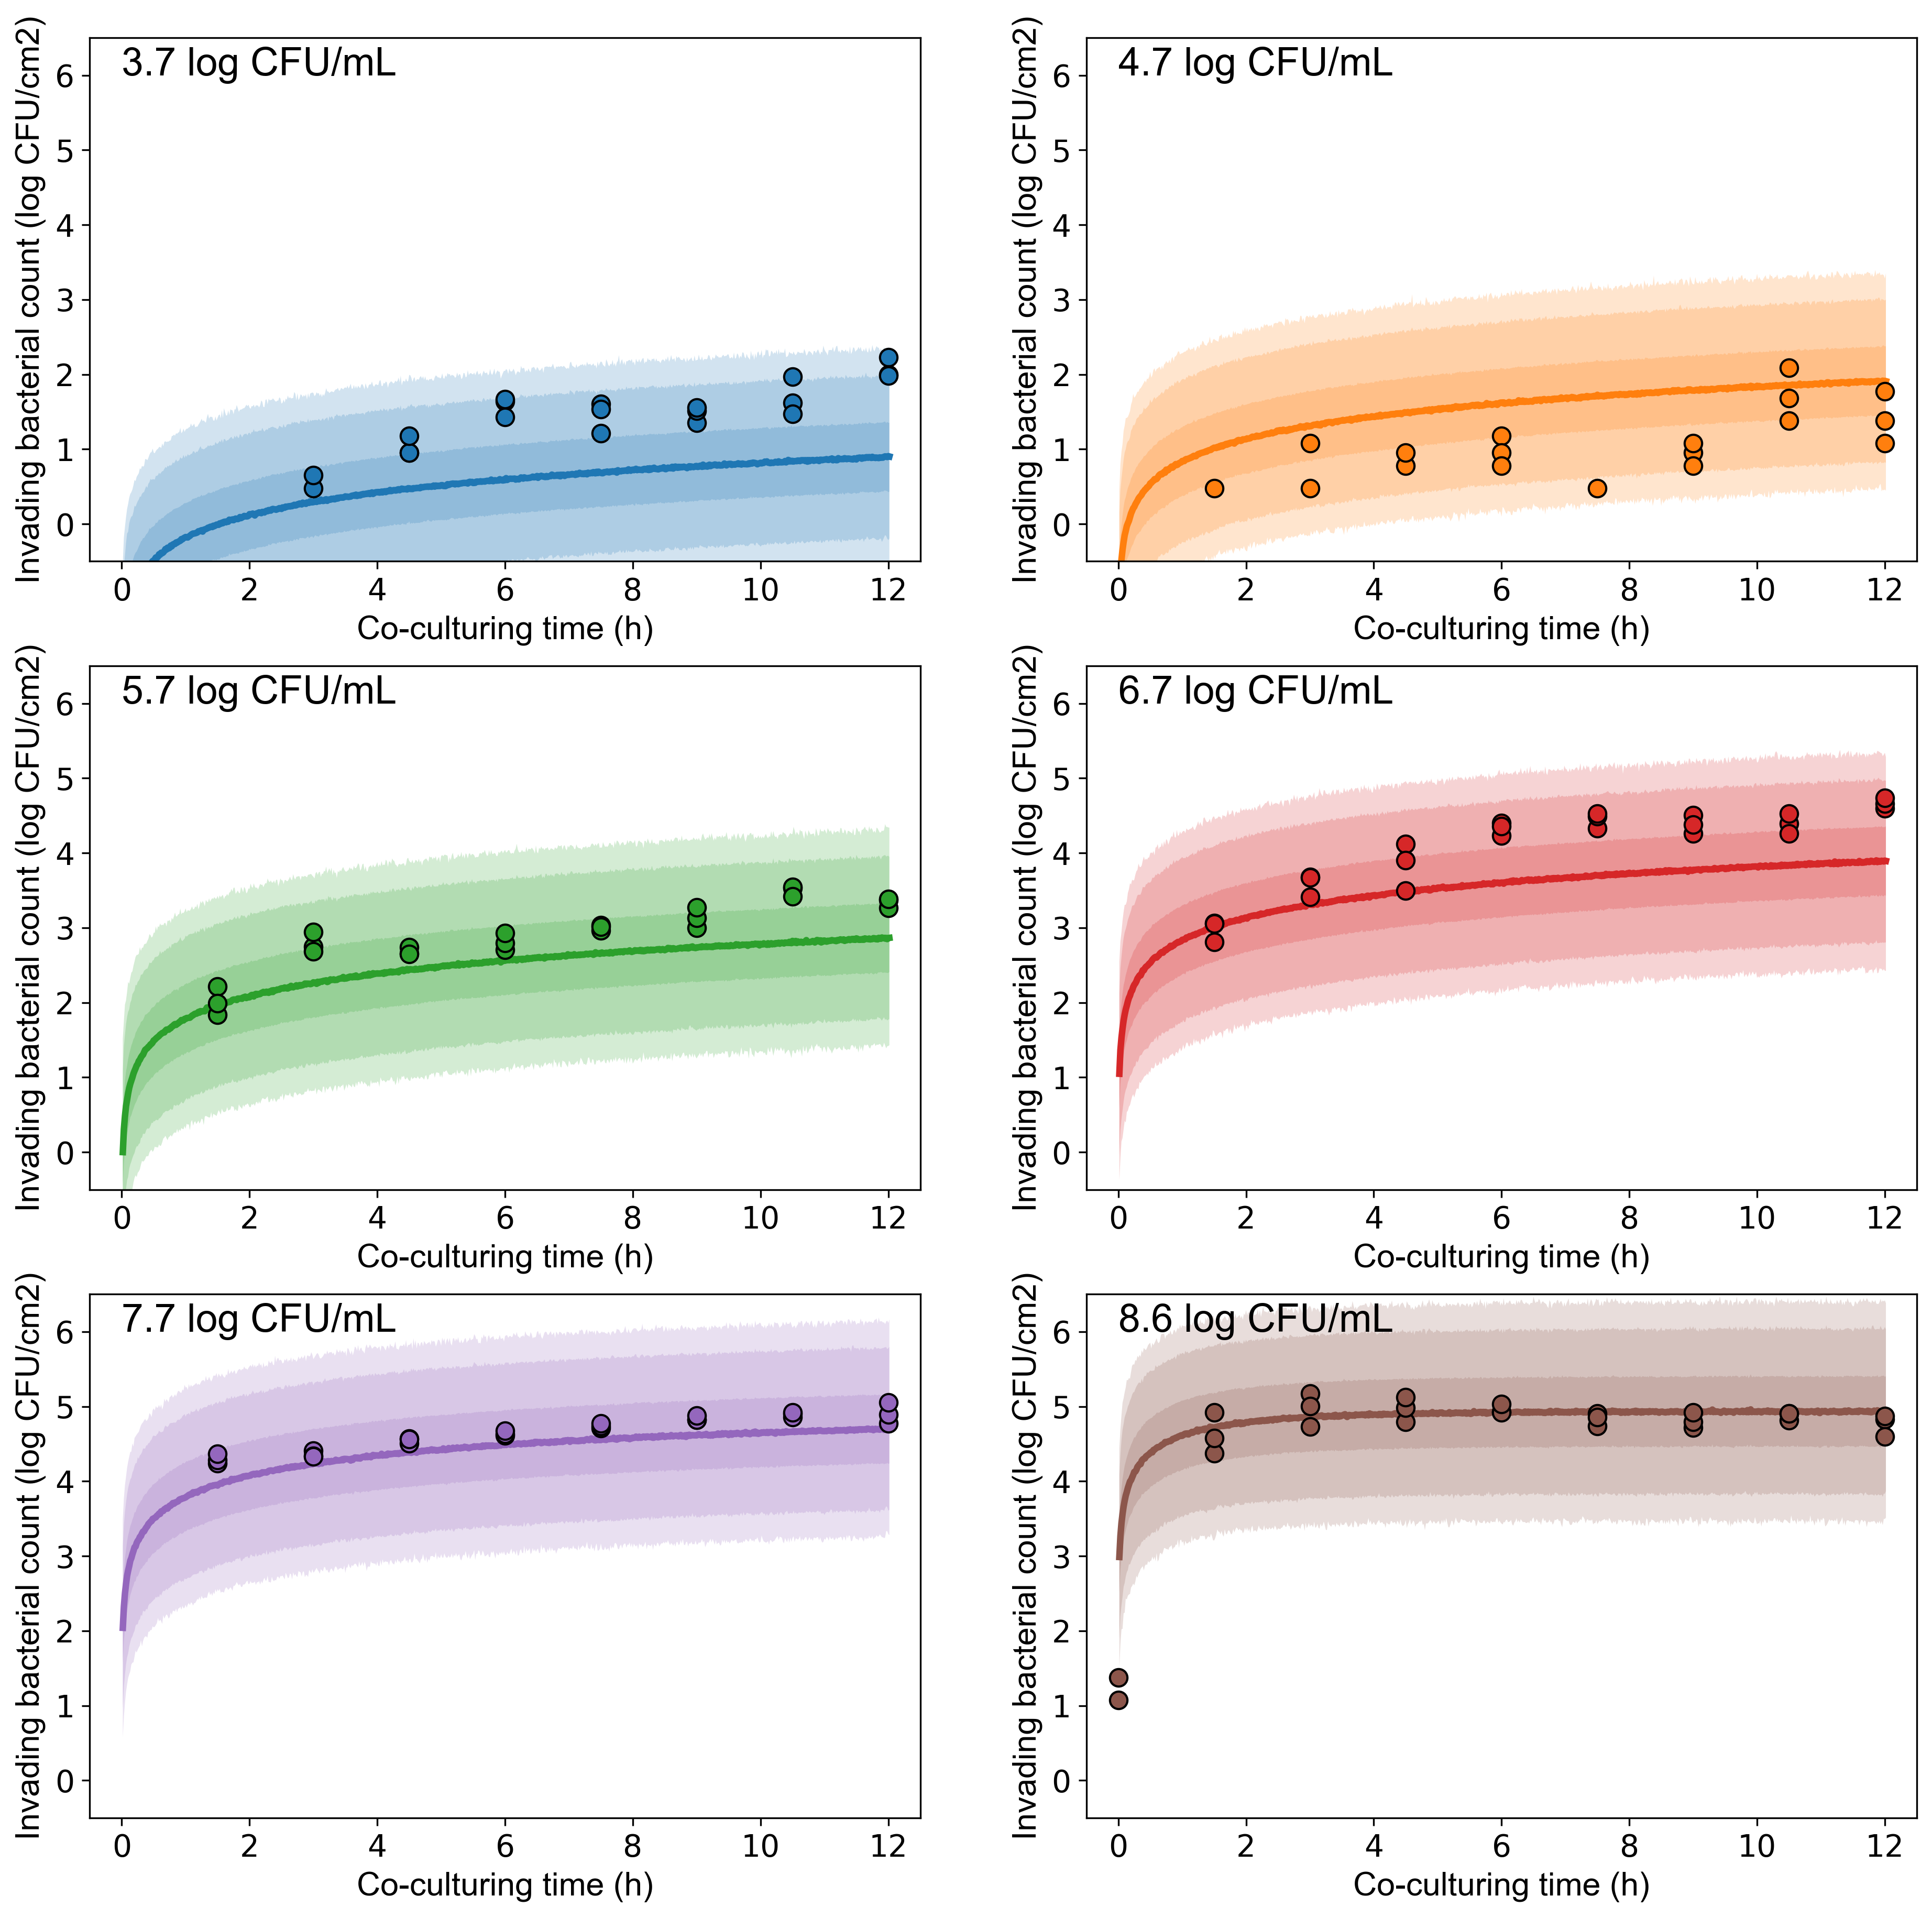

In [15]:
pdf = PdfPages("plot/027/Bayesian Fitted Bacterial Invasion per well.pdf")

plt.figure(1,figsize=(15,15), dpi=300)

for i in tqdm(range(len(class_LogDose)),desc='Progress', leave=False):
    plt.subplot(3,2,i+1)
    plt.ylabel("Invading bacterial count (log CFU/cm2)",size=15,fontname="Arial")
    plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
    plt.text(0,6,str(round(class_LogDose[i],1))+" log CFU/mL",size=18,fontname="Arial")
    plt.axis([-0.5,12.5,-0.5,6.5],fontname="Arial")
    plt.xticks(size=14)
    plt.yticks(size=14)
    LogNdose = class_LogDose[i]
    y_conf_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
    y_predict_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
    for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
        for k in range(Num_mcmc):
            mu = Fit_Model(time_interval[j], LogNdose, samples["LogNmax"][k], samples["Logmu"][k])
            sigma = samples["sigma"][k]
            y_predict_mcmc[j,k] = y_predict_mcmc[j,k] = np.random.normal(mu, sigma)
    y_predict_mcmc = pd.DataFrame(y_predict_mcmc)
    y_predict_percentile = Sample_percentile(time_interval,y_predict_mcmc)
    plt.plot(y_predict_percentile["Time"],y_predict_percentile["50"],color=Palette[i],linewidth=3)
    plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["0.5"],y_predict_percentile["99.5"],facecolor=Palette[i],alpha=0.2)
    plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["2.5"],y_predict_percentile["97.5"],facecolor=Palette[i],alpha=0.2)
    plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["20"],y_predict_percentile["80"],facecolor=Palette[i],alpha=0.2)
    plt.plot(
        name[i]["Time"],np.log10(name[i]["CFU"]),
        marker="o",
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color="None"
    )

plt.subplots_adjust(wspace=0.2,hspace=0.2)

pdf.savefig()

pdf.close()

plt.show()

In [16]:
LogNmax = samples["LogNmax"]
Logmu = samples["Logmu"]
sigma = samples["sigma"]
para_matrix  = pd.DataFrame(np.arange(len(LogNmax)*3).reshape(len(LogNmax), 3), columns=["LogNmax", "Logmu", "sigma"])
para_matrix["LogNmax"] = LogNmax
para_matrix["Logmu"] = Logmu
para_matrix["sigma"] = sigma


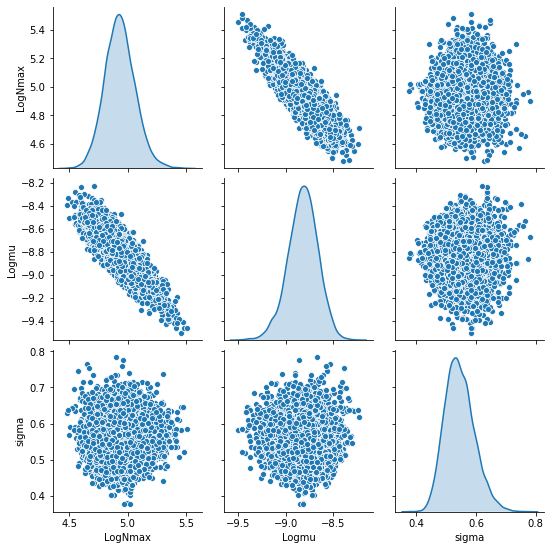

In [17]:
pdf = PdfPages("plot/027/Parameter matrix.pdf")

pg = sns.pairplot(para_matrix, diag_kind='kde')

pdf.savefig()

pdf.close()

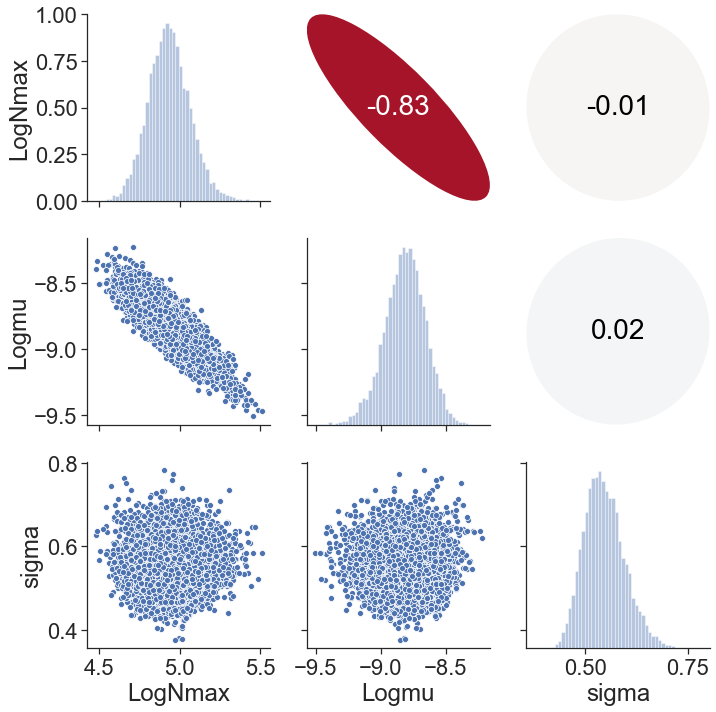

In [18]:
def paramatrix(x, y, **kws):
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis('off')
    ellcolor = plt.cm.RdBu(0.5*(r+1))
    txtcolor = 'black' if math.fabs(r) < 0.5 else 'white'
    ax.add_artist(Ellipse(xy=[.5, .5], width=math.sqrt(1+r), height=math.sqrt(1-r), angle=45,
        facecolor=ellcolor, edgecolor='none', transform=ax.transAxes))
    ax.text(.5, .5, '{:.2f}'.format(r), color=txtcolor, fontsize=28,
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

LogNmax = samples["LogNmax"]
Logmu = samples["Logmu"]
sigma = samples["sigma"]
para_matrix  = pd.DataFrame(np.arange(len(LogNmax)*3).reshape(len(LogNmax), 3), columns=["LogNmax", "Logmu", "sigma"])
para_matrix["LogNmax"] = LogNmax
para_matrix["Logmu"] = Logmu
para_matrix["sigma"] = sigma
    
pdf = PdfPages("plot/027/Parameter matrix.pdf")

sns.set(font_scale=2)
sns.set_style(style="ticks")
g = sns.PairGrid(para_matrix)
g = g.map_lower(sns.scatterplot)
g = g.map_diag(sns.distplot, kde=False)
g = g.map_upper(paramatrix)
g.fig.subplots_adjust(wspace=0.2, hspace=0.2)
g.fig.set_figheight(10)
g.fig.set_figwidth(10)

pdf.savefig()

pdf.close()

In [19]:
with open('fit_27.pkl', 'wb') as g:

    pickle.dump(fit_nuts, g)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until
